# Cat and Dog Semantic Segmentation

## Import Dependencies

In [2]:
import os
import copy
import math
import random
import datetime
from pathlib import Path

import cv2
import mlflow
import mlflow.tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt

## Classes and Functions

### Dataloader

In [3]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self,
                 dataset,
                 dataset_size, # insert len of img_path from Load_Dataset class
                 batch_size,
                 shuffle=False):

        self.dataset = dataset
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.indexes = np.arange(self.dataset_size)

        self.on_epoch_end()

    def __len__(self):
        # Number of Batches per Epoch
        return int(np.floor(self.dataset_size / self.batch_size))  # len(self.list_IDs)

    def __getitem__(self,i):
        start = i * self.batch_size
        stop = (i+1) * self.batch_size
        data = []

        for j in range(start,stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def on_epoch_end(self):
        #self.indexes = np.arange(self.dataset_size)

        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### split_data (fn)

In [4]:
def split_data(img_inputs: list,mask_inputs: list,specie_dict: dict, include_test=True) -> dict:
    ClassList_dict = {}
    classes = ["background","cat","dog"]

    for class_ in classes:
        specie_index = classes.index(class_)
        ClassList_dict[class_] = {"img" : [img_  for img_  in img_inputs  if specie_dict[(img_.split(".")[0])]  == specie_index],
                                    "mask": [mask_ for mask_ in mask_inputs if specie_dict[(mask_.split(".")[0])] == specie_index]
                                    }

    split_setting = {"train" : 0.9,
                     "valid" : 0.08,
                     "test" : 0.02}
    if not include_test:
        split_setting["valid"] = split_setting["test"]
        del split_setting["test"]

    dataset_list = list(split_setting.keys())
    all_dataset = {}

    prev_length = [0] * len(classes)
    start = [0] * len(classes)
    end = [0] * len(classes)

    for ds in dataset_list:
        temp_img_list = []
        temp_mask_list = []

        for class_ in classes:

            # SKIP: for background because all images have cat or dog (background image list has 0 length)
            if len(ClassList_dict[class_]["img"]) == 0:
                continue

            specie_index = classes.index(class_)

            start = copy.deepcopy(prev_length)
            dataset_length = math.floor( split_setting[ds] * len(ClassList_dict[class_]["img"]))
            end[specie_index] = start[specie_index] + dataset_length

            # slice until the end of the list
            if ds == dataset_list[-1]:
                end[specie_index] = None

            # sample: cat_img_list = ClassList_dict["cat"]["img"] -> ["catName01.jpg", "catName02.jpg", ...]
            start_now = start[specie_index]
            end_now = end[specie_index]
            temp_img_list.extend([img_    for img_   in ClassList_dict[class_]["img"][start_now:end_now]   ])
            temp_mask_list.extend([mask_  for mask_  in ClassList_dict[class_]["mask"][start_now:end_now]  ])

        prev_length = copy.deepcopy(end)
        all_dataset[ds] =   {"img" : temp_img_list,
                             "mask": temp_mask_list}

    return all_dataset

### Load_Dataset

In [5]:
class Load_Dataset:
    def __init__(self,
                img_dir, mask_dir,
                img_list, mask_list,
                specie_dict,
                classes, classes_limit,
                fix_mask):

        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ids = img_list
        self.mask_ids = mask_list

        self.specie_dict = specie_dict
        self.classes = classes

        self.img_path = [str(Path(self.img_dir,img_id)) for img_id in self.img_ids]
        self.mask_path = [str(Path(self.mask_dir,mask_id)) for mask_id in self.mask_ids]

        # Count classes and their number {"cat": 500, "dog": 1500}
        self.class_count = self.class_counter()

        # classes = 0: background || 1: cat || 2: dog   class_val = [0,1,2]
        if classes_limit:
            self.class_val = [self.classes.index(cls) for cls in classes_limit]
        else:
            self.class_val = [i for i,_ in enumerate(self.classes)]

        self.fix_mask = fix_mask


    def __getitem__(self,i):
        # read img and mask
        img = cv2.imread(self.img_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.img_preprocess(img)

        mask = cv2.imread(self.mask_path[i],0)
        mask = self.mask_to_onehot(mask)

        return img, mask

    def img_preprocess(self,img):
        #resize
        preprocess_img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
        #normalize
        preprocess_img = (preprocess_img/127.5) - 1.0

        return preprocess_img

    def mask_to_onehot(self,mask):

        # separate classes into their own channels
        ## if mask values in list of classes (class_values) return true
        masks = [(mask == class_) for class_ in self.class_val]
        ## stack 2d masks (list) into a single 3d array (True = 1, False = 0)
        ## axis = -1 > add another axis || example shape (500,500, n_classes)
        mask = np.stack(masks, axis = -1).astype('float')

        mask= cv2.resize(mask, (224,224), interpolation=cv2.INTER_LINEAR)
        onehot_mask = np.round(mask)

        return onehot_mask

    def class_counter(self):
        # classes=["background","cat","dog"]
        name_list = [class_.split(os.path.sep)[-1].split(".")[0] for class_ in self.img_path]
        specie_list = [self.specie_dict.get(name,None) for name in name_list]
        class_count = {class_name: specie_list.count(class_id) for class_id,class_name in enumerate(self.classes) if class_name != "background"}

        return class_count

### undersample (fn)

In [6]:
def undersample(img_list,mask_list,specie_dict):
    data_class = {'dog':[],'cat':[]}

    for img in img_list:
        if specie_dict[img.split('.')[0]] == 2:
            data_class['dog'].append(img.split('.')[0])
        elif specie_dict[img.split('.')[0]] == 1:
            data_class['cat'].append(img.split('.')[0])

    joined_class = data_class['cat'] + data_class['dog'][:len(data_class['cat'])]

    out_img = [img for img in img_list if img.split('.')[0] in joined_class]
    out_mask = [mask for mask in mask_list if mask.split('.')[0] in joined_class]

    return out_img,out_mask

### visualize_class_distribution (fn)

In [7]:
def visualize_class_distribution(img_list:list[str],img_label:dict[str,int],map_label:dict[int,str]=None,
                                 title:str='Class Count Comparison',
                                 xlabel:str='Species',
                                 ylabel:str='Count',
                                 figsize:tuple[int,int]=None):

    if map_label:
        assert set(img_label.values()) == set(map_label.keys()), "incomplete map_label"

    classes = set(img_label.values())
    class_count = [len([1 for img in img_list if img.split('.')[0] in img_label and img_label[img.split('.')[0]] == class_ ]) for class_ in classes]

    class_names = [map_label[label] for label in classes] if map_label else list(classes)

    if figsize:
        plt.figure(figsize=figsize)

    plt.bar(class_names,class_count)
    plt.xticks(class_names,rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### class_splitter (fn)

In [8]:
def class_splitter(img_list:list[str], img_label:dict[str,int],file_ext:str) -> dict[str,list[str]]:
    """
    Split img_list into their own labels

    NOTE: if img_file from img_list does not exist in img_label, it will not be included in the output of this function

    Parameters:
    img_list:   List of images
    NOTE:       Remove file extension from each img_file
                Ex. ["dog_name.jpg",...] to ["dog_name",...]

    img_label:  Label for each img_file (Cat:1 , Dog:2)
    Ex.         ['dog_name':2,'cat_name':1]

    file_ext:   .jpg or .png after the file_name


    """
    class_split = {class_:[img+file_ext for img in img_list if img in img_label and img_label[img]==class_] for class_ in set(img_label.values())}

    return class_split

### dataset_splitter (fn)

In [9]:
def dataset_splitter(img_list:list[str],mask_list:list[str],train:float,valid:float,test:float,shuffle:bool=False,rand_seed:int=5) -> dict[str, dict[str,list[str]]]:
    """
    Split data into train, valid, test datasets

    Parameters:
    img_list: list of images
    Ex. [dog_img.jpg,...]

    mask_list: list of masks
    Ex. [dog_mask.png,...]

    train,valid,test: fraction of data that is going to be split into train,valid,test sets

    rand_seed: to achieve similar results during shuffling
    """

    if shuffle:
        random.seed(rand_seed)

        zipped = list(zip(img_list,mask_list))
        random.shuffle(zipped)
        img_list, mask_list = zip(*zipped)

    assert round(train + valid + test,1) == 1.0, "sum of train,valid,test must be equal to 1"

    train_count = int(train*(len(img_list)))
    valid_count = int((train+valid)*(len(img_list)))
    test_count =  int((train+valid+test)*(len(img_list)))



    dataset = {"train":     {"img":img_list[:train_count],
                            "mask": mask_list[:train_count]},

               "valid":     {"img":img_list[train_count:valid_count],
                            "mask": mask_list[train_count:valid_count]},

               "test":      {"img":img_list[valid_count:test_count+1],
                            "mask": mask_list[valid_count:test_count+1]}

               }

    return dataset

## Load Data

### Directories

In [10]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR,"data")
IMG_DIR = os.path.join(DATA_DIR,"img")
MASK_DIR = os.path.join(DATA_DIR,"mask")

### Dataframe

In [11]:
df = pd.read_csv((os.path.join(DATA_DIR,'list.txt')), comment='#',header=None, sep=" ")
df.columns = ['image_name','class_index','specie_index','breed_index']
df = df.sort_values(by = 'image_name', ascending=True)
df = df.reset_index(drop=True)

# Get dict ("image_name": specie_index)
specie_dict = df.set_index("image_name")["specie_index"].to_dict()

In [12]:
cat_breed_dict = df[df['specie_index'] == 1].set_index('image_name')['breed_index'].to_dict()
dog_breed_dict = df[df['specie_index'] == 2].set_index('image_name')['breed_index'].to_dict()
print(cat_breed_dict)
print(dog_breed_dict)

{'Abyssinian_1': 1, 'Abyssinian_10': 1, 'Abyssinian_100': 1, 'Abyssinian_101': 1, 'Abyssinian_102': 1, 'Abyssinian_103': 1, 'Abyssinian_104': 1, 'Abyssinian_105': 1, 'Abyssinian_106': 1, 'Abyssinian_107': 1, 'Abyssinian_108': 1, 'Abyssinian_109': 1, 'Abyssinian_11': 1, 'Abyssinian_110': 1, 'Abyssinian_111': 1, 'Abyssinian_112': 1, 'Abyssinian_113': 1, 'Abyssinian_114': 1, 'Abyssinian_115': 1, 'Abyssinian_116': 1, 'Abyssinian_117': 1, 'Abyssinian_118': 1, 'Abyssinian_119': 1, 'Abyssinian_12': 1, 'Abyssinian_120': 1, 'Abyssinian_121': 1, 'Abyssinian_122': 1, 'Abyssinian_123': 1, 'Abyssinian_124': 1, 'Abyssinian_125': 1, 'Abyssinian_126': 1, 'Abyssinian_127': 1, 'Abyssinian_128': 1, 'Abyssinian_129': 1, 'Abyssinian_13': 1, 'Abyssinian_130': 1, 'Abyssinian_131': 1, 'Abyssinian_132': 1, 'Abyssinian_133': 1, 'Abyssinian_134': 1, 'Abyssinian_135': 1, 'Abyssinian_136': 1, 'Abyssinian_137': 1, 'Abyssinian_138': 1, 'Abyssinian_139': 1, 'Abyssinian_14': 1, 'Abyssinian_140': 1, 'Abyssinian_141': 1

In [13]:
subclass_dict = df.set_index("image_name")["class_index"].to_dict()
print(subclass_dict)

{'Abyssinian_1': 1, 'Abyssinian_10': 1, 'Abyssinian_100': 1, 'Abyssinian_101': 1, 'Abyssinian_102': 1, 'Abyssinian_103': 1, 'Abyssinian_104': 1, 'Abyssinian_105': 1, 'Abyssinian_106': 1, 'Abyssinian_107': 1, 'Abyssinian_108': 1, 'Abyssinian_109': 1, 'Abyssinian_11': 1, 'Abyssinian_110': 1, 'Abyssinian_111': 1, 'Abyssinian_112': 1, 'Abyssinian_113': 1, 'Abyssinian_114': 1, 'Abyssinian_115': 1, 'Abyssinian_116': 1, 'Abyssinian_117': 1, 'Abyssinian_118': 1, 'Abyssinian_119': 1, 'Abyssinian_12': 1, 'Abyssinian_120': 1, 'Abyssinian_121': 1, 'Abyssinian_122': 1, 'Abyssinian_123': 1, 'Abyssinian_124': 1, 'Abyssinian_125': 1, 'Abyssinian_126': 1, 'Abyssinian_127': 1, 'Abyssinian_128': 1, 'Abyssinian_129': 1, 'Abyssinian_13': 1, 'Abyssinian_130': 1, 'Abyssinian_131': 1, 'Abyssinian_132': 1, 'Abyssinian_133': 1, 'Abyssinian_134': 1, 'Abyssinian_135': 1, 'Abyssinian_136': 1, 'Abyssinian_137': 1, 'Abyssinian_138': 1, 'Abyssinian_139': 1, 'Abyssinian_14': 1, 'Abyssinian_140': 1, 'Abyssinian_141': 1

In [14]:
# display dataframe
print(df)

                image_name  class_index  specie_index  breed_index
0             Abyssinian_1            1             1            1
1            Abyssinian_10            1             1            1
2           Abyssinian_100            1             1            1
3           Abyssinian_101            1             1            1
4           Abyssinian_102            1             1            1
...                    ...          ...           ...          ...
7344  yorkshire_terrier_95           37             2           25
7345  yorkshire_terrier_96           37             2           25
7346  yorkshire_terrier_97           37             2           25
7347  yorkshire_terrier_98           37             2           25
7348  yorkshire_terrier_99           37             2           25

[7349 rows x 4 columns]


Used to identify if the file name contains a dog or cat (Specie 1: Cat and Specie 2: Dog)

In [15]:
# view specie dict
print(specie_dict)

{'Abyssinian_1': 1, 'Abyssinian_10': 1, 'Abyssinian_100': 1, 'Abyssinian_101': 1, 'Abyssinian_102': 1, 'Abyssinian_103': 1, 'Abyssinian_104': 1, 'Abyssinian_105': 1, 'Abyssinian_106': 1, 'Abyssinian_107': 1, 'Abyssinian_108': 1, 'Abyssinian_109': 1, 'Abyssinian_11': 1, 'Abyssinian_110': 1, 'Abyssinian_111': 1, 'Abyssinian_112': 1, 'Abyssinian_113': 1, 'Abyssinian_114': 1, 'Abyssinian_115': 1, 'Abyssinian_116': 1, 'Abyssinian_117': 1, 'Abyssinian_118': 1, 'Abyssinian_119': 1, 'Abyssinian_12': 1, 'Abyssinian_120': 1, 'Abyssinian_121': 1, 'Abyssinian_122': 1, 'Abyssinian_123': 1, 'Abyssinian_124': 1, 'Abyssinian_125': 1, 'Abyssinian_126': 1, 'Abyssinian_127': 1, 'Abyssinian_128': 1, 'Abyssinian_129': 1, 'Abyssinian_13': 1, 'Abyssinian_130': 1, 'Abyssinian_131': 1, 'Abyssinian_132': 1, 'Abyssinian_133': 1, 'Abyssinian_134': 1, 'Abyssinian_135': 1, 'Abyssinian_136': 1, 'Abyssinian_137': 1, 'Abyssinian_138': 1, 'Abyssinian_139': 1, 'Abyssinian_14': 1, 'Abyssinian_140': 1, 'Abyssinian_141': 1

### list of images and masks

In [16]:
img_inputs = [img_ for img_ in os.listdir(IMG_DIR) if not img_.startswith(".") and (img_.endswith(".jpg") or img_.endswith(".png"))]
mask_inputs = [mask_ for mask_ in os.listdir(MASK_DIR) if not mask_.startswith(".") and (mask_.endswith(".jpg") or mask_.endswith(".png"))]
img_inputs = sorted(img_inputs)
mask_inputs = sorted(mask_inputs)
print(img_inputs)
print(mask_inputs)

['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_101.jpg', 'Abyssinian_102.jpg', 'Abyssinian_103.jpg', 'Abyssinian_104.jpg', 'Abyssinian_105.jpg', 'Abyssinian_106.jpg', 'Abyssinian_107.jpg', 'Abyssinian_108.jpg', 'Abyssinian_109.jpg', 'Abyssinian_11.jpg', 'Abyssinian_110.jpg', 'Abyssinian_111.jpg', 'Abyssinian_112.jpg', 'Abyssinian_113.jpg', 'Abyssinian_114.jpg', 'Abyssinian_115.jpg', 'Abyssinian_116.jpg', 'Abyssinian_117.jpg', 'Abyssinian_118.jpg', 'Abyssinian_119.jpg', 'Abyssinian_12.jpg', 'Abyssinian_120.jpg', 'Abyssinian_121.jpg', 'Abyssinian_122.jpg', 'Abyssinian_123.jpg', 'Abyssinian_124.jpg', 'Abyssinian_125.jpg', 'Abyssinian_126.jpg', 'Abyssinian_127.jpg', 'Abyssinian_128.jpg', 'Abyssinian_129.jpg', 'Abyssinian_13.jpg', 'Abyssinian_130.jpg', 'Abyssinian_131.jpg', 'Abyssinian_132.jpg', 'Abyssinian_133.jpg', 'Abyssinian_134.jpg', 'Abyssinian_135.jpg', 'Abyssinian_136.jpg', 'Abyssinian_137.jpg', 'Abyssinian_138.jpg', 'Abyssinian_139.jpg', 'Abyssinian_14.

## Models

### VGG16-UNet

In [17]:
width, height = 224, 224

base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_conv2', # 224,224,64
    'block2_conv2', # 112,112,128
    'block3_conv3', # 56,56,256
    'block4_conv3', # 28,28,512
    'block5_conv3', # 14,14,512
    'block5_pool',  # 7,7,512
]

base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False # False

# change to mod_VGG_16
VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

def VGG16_Unet_decoder(expansive_input,
                     contractive_input,
                     n_filters=32):

  # deconvolution
  # new shape = [(shape + 2(padding) - kernel_size)/stride]  + 1 (reverse this formula for deconvolution new shape)
  # doubles shape size
  up = tfl.Conv2DTranspose(filters = n_filters,
                         kernel_size = 3,
                         strides = 2,
                         padding = 'same')(expansive_input)

  # combine expansive and contractive conv
  merge = tfl.concatenate([up,contractive_input], axis = 3)

  # kernel_initializer="he_normal" helps to mitigate vanishing and exploding gradients problem
  conv = tfl.Conv2D(filters = n_filters,
                  kernel_size = 3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)

  conv = tfl.Conv2D(filters = n_filters,
                  kernel_size = 3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

  return conv

def VGG16_Unet(n_classes):
    """
        VGG16 = contract1,contract2,contract3, contract4, contract5
        contract5 -> conv2d -> conv2d

        'block1_conv2', # 224,224,64
        'block2_conv2', # 112,112,128
        'block3_conv3', # 56,56,256
        'block4_conv3', # 28,28,512
        'block5_conv3', # 14,14,512
        'block5_pool',  # 7,7,512
    """
    inputs = tf.keras.layers.Input(shape=(224,224,3))

    contract_blocks = VGG_16(inputs)

    # last maxpool to connect to conv2d
    cb_last = contract_blocks[-1]

    # cb_last contains 512 filters, (7x7)
    # applying padding="same" results in p = 1
    # new shape = [(shape + 2(padding) - kernel_size)/stride]  + 1
    # new shape = 7
    conv_last1 = tfl.Conv2D(filters = 1024,
                    kernel_size = 3,
                    activation='relu',
                    padding='same',
                    kernel_initializer='he_normal')(cb_last)

    conv_last2 = tfl.Conv2D(filters = 1024,
                    kernel_size = 3,
                    activation='relu',
                    padding='same',
                    kernel_initializer='he_normal')(conv_last1)


    # expansive path (concatenate )

    ## fifth block
    conv_5 = VGG16_Unet_decoder(expansive_input = conv_last2,
                        contractive_input = contract_blocks[4],
                        n_filters= 512)

    ## fourth block
    conv_4 = VGG16_Unet_decoder(expansive_input = conv_5,
                        contractive_input = contract_blocks[3],
                        n_filters= 512)

    ## third block

    conv_3 = VGG16_Unet_decoder(expansive_input = conv_4,
                        contractive_input = contract_blocks[2],
                        n_filters= 256)

    ## second block
    conv_2 = VGG16_Unet_decoder(expansive_input = conv_3,
                        contractive_input = contract_blocks[1],
                        n_filters= 128)

    ## first block

    conv_1 = VGG16_Unet_decoder(expansive_input = conv_2,
                        contractive_input = contract_blocks[0],
                        n_filters= 64)


    conv_out = tfl.Conv2D(filters = 64,
                    kernel_size = 3,
                    activation='relu',
                    padding='same',
                    kernel_initializer='he_normal')(conv_1)



    conv_out = tfl.Conv2D(filters = n_classes, kernel_size = 1, padding='same',activation='softmax')(conv_out)

    model = tf.keras.Model(inputs=inputs,outputs=conv_out)

    return model

2023-11-26 22:58:44.620019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 22:58:44.630523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 22:58:44.630594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 22:58:44.632940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 22:58:44.633001: I tensorflow/compile

## Metrics

### IoU

In [18]:
def IoU(y_true, y_pred, smooth=1e-6):
  # intersection returns a shape of (n_samples,) because everything is summed
  intersection = tf.math.reduce_sum(tf.abs(y_true * y_pred), axis=(1,2,3))
  union = tf.math.reduce_sum(y_true,axis=(1,2,3))+tf.math.reduce_sum(y_pred,axis=(1,2,3))-intersection
  iou = tf.math.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [19]:
tensor = np.random.randint(0,2,(2, 3, 3, 2))
tensor2 = np.random.randint(0,2,(2, 3, 3, 2))
tensor_input = tf.cast(tensor,dtype=tf.float32)
tensor_input2 = tf.cast(tensor2,dtype=tf.float32)
IoU(tensor_input,tensor_input2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.31547624>

### Sensitivity

When the actual value is positive, how often is the prediction correct?

$$Sensitivity(TPR) = \frac{TP}{TP+FN}$$

In [20]:
def classification_metrics(y_true,y_pred, threshold=0.5):

    """
    TP -> y_true 1s and y_pred 1s 
    TN -> y_true 0s and y_pred 0s
    FP -> y_true 0s and y_pred 1s
    FN -> y_true 1s and y_pred 0s
    """
    y_true = tf.cast(y_true,dtype=tf.int32)
    y_pred_adj = tf.identity(y_pred)

    y_pred_adj = tf.cast(y_pred_adj > threshold, dtype=tf.int32)

    TP = tf.size(tf.where(tf.equal(y_true + y_pred_adj, 2)))
    TN = tf.size(tf.where(tf.equal(y_true + y_pred_adj, 0)))
    FP = tf.size(tf.where(tf.equal(y_true - y_pred_adj, -1)))
    FN = tf.size(tf.where(tf.equal(y_true - y_pred_adj, 1)))

    return (TP,TN,FP,FN)

In [21]:
def sensitivity(y_true, y_pred,threshold=0.5,smooth=1e-6):
    
    TP,_,_,FN = classification_metrics(y_true,y_pred, threshold)
    TP,FN = tf.cast(TP,dtype=tf.float32),tf.cast(FN,dtype=tf.float32)

    TPR = (TP+smooth)/(TP+FN+smooth)

    return TPR

In [22]:
tensor = np.random.randint(0,2,(2, 3, 3, 2))
tensor2 = np.random.rand(2,1,1,2)
tensor_input = tf.cast(tensor,dtype=tf.float32)
tensor_input2 = tf.cast(tensor2,dtype=tf.float32)

sensitivity(tensor_input,tensor_input)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

### Specificity

When the actual value is negative, how often is the prediction correct?

$$Specificity(TNR) = \frac{TN}{TN+FP}$$

In [23]:
def specificity(y_true, y_pred, threshold=0.5, smooth=1e-6):
    _,TN,FP,_ = classification_metrics(y_true,y_pred, threshold)
    TN,FP = tf.cast(TN,dtype=tf.float32),tf.cast(FP,dtype=tf.float32)

    TNR = (TN+smooth)/(TN+FP+smooth)

    return TNR

In [24]:
tensor = np.random.randint(0,2,(2, 3, 3, 2))
tensor2 = np.random.rand(2,1,1,2)
tensor_input = tf.cast(tensor,dtype=tf.float32)
tensor_input2 = tf.cast(tensor2,dtype=tf.float32)

specificity(tensor_input,tensor_input)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

## Loss Functions

### Dice Loss 

- smooth is added to prevent 0 division

$$DL(y,\hat{p}) = 1 - \frac{2y\hat{p}+smooth}{y+\hat{p}+smooth}$$

Example calculation on how it works:

$$2y\hat{p}+smooth = 

2

\begin{bmatrix}
0.01 & 0.03 & 0.02 & 0.02 \\
0.05 & 0.12 & 0.09 & 0.07 \\
0.89 & 0.85 & 0.88 & 0.91 \\
0.99 & 0.97 & 0.95 & 0.97
\end{bmatrix}
*
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 
\end{bmatrix}

+ 1e^{-6}
$$

$$2y\hat{p}+smooth = 2 \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0.89 & 0.85 & 0.88 & 0.91 \\
0.99 & 0.97 & 0.95 & 0.97
\end{bmatrix}
+1e^{-6}
= 2 \times 7.41 + 1e^{-6}
= 14.82 \times 10^{-6}
$$

$$y+\hat{p}+smooth = 

\begin{bmatrix}
0.01 & 0.03 & 0.02 & 0.02 \\
0.05 & 0.12 & 0.09 & 0.07 \\
0.89 & 0.85 & 0.88 & 0.91 \\
0.99 & 0.97 & 0.95 & 0.97
\end{bmatrix}

+ 

\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 
\end{bmatrix}


+ 1e^{-6}

$$

$$y+\hat{p}+smooth = 7.82 + 8 + 1e^{-6} = 15.82 \times 10^{-6}$$

$$DL(y,\hat{p}) = 1 - \frac{14.82 \times 10^{-6}}{15.82 \times 10^{-6}} = 0.0632$$

In [25]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-7, gamma=1):
        super(DiceLoss, self).__init__()
        self.name = 'DiceLoss'
        self.smooth = smooth
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # shape (batch_size,width,height,n_classes)
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        
        # shape (batch_size,n_classes)
        numerator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true),axis=(1,2)) + self.smooth
        denominator = tf.reduce_sum(y_pred ** self.gamma,axis=(1,2)) + tf.reduce_sum(y_true ** self.gamma,axis=(1,2)) + self.smooth
        
        # get the average dice loss of all the classes
        # shape (batch_size,)
        dice_loss_per_batch = 1 - tf.reduce_mean(tf.divide(numerator, denominator),axis=-1)

        return dice_loss_per_batch

### Focal Loss

Derivation:

$$FL(p_t) = -\alpha_t (1-p_t)^\gamma \log{(p_t)}$$

$$p_t = 
\begin{cases}
p, & \text{if y=1} \\
1-p,& \text{otherwise}
\end{cases}$$

$$FL(p_t) = -\alpha_t (y(1-\hat{y})^\gamma \ \log(\hat{y})  \ + \ (1-y)(\hat{y})^\gamma \ \log(1-\hat{y}) )$$

In [26]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.name = 'FocalLoss'
        self.smooth = smooth
        self.gamma = gamma
        self.alpha = alpha
        self.BCE = tf.keras.losses.BinaryCrossentropy()

    def call(self,y_true,y_pred):

        # shape (batch_size,width,height,n_classes)
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)

        #tf.print("y_true shape: ",y_true.shape)

        # get BCE
        loss_bce = self.BCE(y_true, y_pred)
        # tf.print("loss_bce: ",loss_bce)
        # tf.print("loss_bce shape: ",loss_bce.shape)

        # pt
        pt = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        #tf.print("pt shape: ",pt.shape)

        # alpha factor
        alpha_t = (y_true*self.alpha) + ((1-y_true)*(1-self.alpha))
        #tf.print("alpha_t shape: ",alpha_t.shape)

        # modulating factor
        mod_f = (1-pt)**self.gamma
        #tf.print("mod_f shape: ",mod_f.shape)

        loss_fl = alpha_t * mod_f * loss_bce
        #tf.print("loss_fl shape: ",loss_fl.shape)

        class_FL = tf.reduce_mean(loss_fl,axis=(1,2))
        #tf.print("class_FL reduce_sum: ",class_FL)
        #tf.print("class_FL reduce_sum shape: ",class_FL.shape)

        class_FL = tf.reduce_mean(class_FL,axis=-1)
        #tf.print("class_FL reduce_mean: ",class_FL)
        #tf.print("class_FL reduce_mean shape: ",class_FL.shape)


        batch_FL = tf.reduce_mean(class_FL)
        #tf.print("batch_FL reduce_mean: ",batch_FL)
        #tf.print("batch_FL reduce_mean shape: ",batch_FL.shape)

        #tf.print("--------------------------------------")

        return batch_FL

### Tversky Loss

$$TL(p,\hat{p}) = 1- \dfrac{\epsilon+p\hat{p}}{\epsilon+p\hat{p}+\beta(1-p)\hat{p}+(1-\beta)p(1-\hat{p})}$$

In [27]:
class TverskyLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, beta=0.7):
        super(TverskyLoss, self).__init__()
        self.name = 'TverskyLoss'
        self.smooth = smooth
        self.beta = beta

    def call(self,y_true,y_pred):

        # shape (batch_size,width,height,n_classes)
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)

        # shape (batch_size,1,1,n_classes)
        numerator = tf.reduce_sum(tf.multiply(y_pred, y_true),axis=(1,2),keepdims=True) + self.smooth

        denominator = tf.reduce_sum(tf.multiply(y_pred, y_true),axis=(1,2),keepdims=True) + \
                      tf.reduce_sum(self.beta * tf.multiply((1-y_true),y_pred),axis=(1,2),keepdims=True) + \
                      tf.reduce_sum((1-self.beta)  * tf.multiply(y_true,(1-y_pred)),axis=(1,2),keepdims=True) + \
                      self.smooth
        
        # shape (batch_size,1,1,1)
        TL_per_class = 1 - tf.reduce_mean(tf.divide(numerator, denominator),axis=-1)

        # shape (1,)

        batch_TL = tf.reduce_mean(TL_per_class)

        # tf.print("\n")
        # tf.print("y_true shape ",y_true.shape)

        # #tf.print("numerator ",numerator)
        # tf.print("numerator shape ", numerator.shape)

        # #tf.print("denominator ",denominator)
        # tf.print("denominator shape ", denominator.shape)

        # #tf.print("numerator / denominator ",tf.divide(numerator, denominator))

        # tf.print(TL_per_class)
        # tf.print("TL_per_class shape ", TL_per_class.shape)

        # tf.print(batch_TL)
        # tf.print("batch_TL shape ", batch_TL.shape)



        return batch_TL

### Focal Tversky Loss

$$FTL = \sum_c (1-TI_c)^{\gamma}$$

$$TI(p,\hat{p}) = \dfrac{p\hat{p}}{p\hat{p}+\beta(1-p)\hat{p}+(1-\beta)p(1-\hat{p})}$$

In [28]:
class FocalTverskyLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, beta=0.7, gamma=2):
        super(FocalTverskyLoss, self).__init__()
        self.name = 'FocalTverskyLoss'
        self.smooth = smooth
        self.beta = beta
        self.gamma = gamma

    def call(self,y_true,y_pred):

        # shape (width,height,n_classes)
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)

        # shape (1,1,n_classes)
        numerator = tf.reduce_sum(tf.multiply(y_pred, y_true),axis=(0,1),keepdims=True) + self.smooth

        denominator = tf.reduce_sum(tf.multiply(y_pred, y_true),axis=(0,1),keepdims=True) + \
                      tf.reduce_sum(self.beta * tf.multiply((1-y_true),y_pred),axis=(0,1),keepdims=True) + \
                      tf.reduce_sum((1-self.beta)  * tf.multiply(y_true,(1-y_pred)),axis=(0,1),keepdims=True) + \
                      self.smooth
        
        FTL = tf.reduce_mean(1 - tf.divide(numerator, denominator))**self.gamma

        return FTL

### Hausdorff distance loss

- Will implement in the future

## RUN

### Split Data

In [29]:
# img_inputs contains two major classes, dog and cat

inp_list = [img.split(".")[0] for img in img_inputs]

# split image and mask pairs based on their subcategory
img_list = class_splitter(inp_list,specie_dict,'.jpg')
mask_list = class_splitter(inp_list,specie_dict,'.png')

train_img = []
train_mask = []
valid_img = []
valid_mask = []
test_img = []
test_mask = []

# iterate over all classes
for img,mask in zip(img_list,mask_list):

    temp_ds = dataset_splitter(img_list[img],mask_list[mask],0.9,0.08,0.02,shuffle=True)
    train_img.extend(temp_ds["train"]["img"])
    train_mask.extend(temp_ds["train"]["mask"])
    valid_img.extend(temp_ds["valid"]["img"])
    valid_mask.extend(temp_ds["valid"]["mask"])
    test_img.extend(temp_ds["test"]["img"])
    test_mask.extend(temp_ds["test"]["mask"])

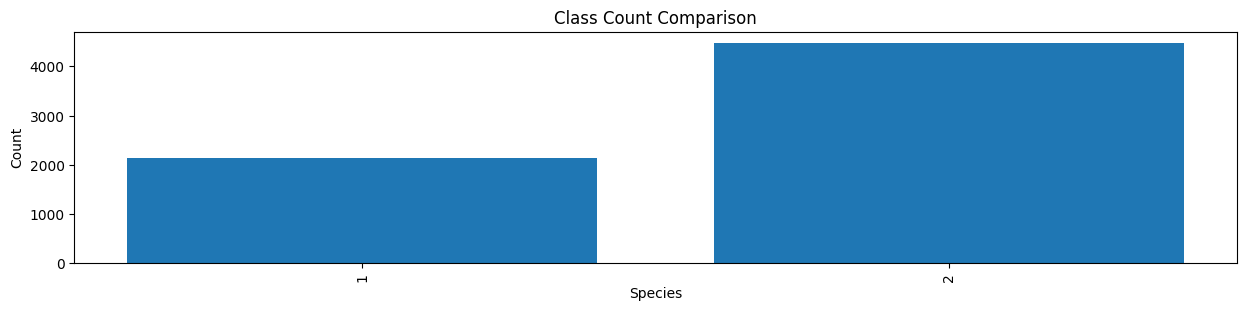

In [30]:
visualize_class_distribution(train_img,specie_dict,figsize=(15,3))

### Load Dataset

In [31]:
train_dataset = Load_Dataset(img_dir = IMG_DIR,
                                        mask_dir = MASK_DIR,
                                        img_list = train_img,
                                        mask_list= train_mask,
                                        specie_dict = specie_dict,
                                        classes=["background","cat","dog"],
                                        classes_limit=False,
                                        fix_mask=True)

valid_dataset = Load_Dataset(img_dir = IMG_DIR,
                                        mask_dir = MASK_DIR,
                                        img_list = valid_img,
                                        mask_list= valid_mask,
                                        specie_dict = specie_dict,
                                        classes=["background","cat","dog"],
                                        classes_limit=False,
                                        fix_mask=True)

test_dataset = Load_Dataset(img_dir = IMG_DIR,
                                        mask_dir = MASK_DIR,
                                        img_list = test_img,
                                        mask_list= test_mask,
                                        specie_dict = specie_dict,
                                        classes=["background","cat","dog"],
                                        classes_limit=False,
                                        fix_mask=True)

### Dataloader

In [32]:
# Batch Gradient Descent: Batch Size = Size of Training Set
# Stochastic Gradient Descent: Batch Size = 1
# Mini-Batch Gradient Descent: 1 < Batch Size < Size of Training Set
loaded_train_dataset = Dataloader(dataset = train_dataset,
                        dataset_size = len(train_dataset.img_path),
                        batch_size = 16,
                        shuffle = True
                        )

loaded_valid_dataset = Dataloader(dataset = valid_dataset,
                            dataset_size = len(valid_dataset.img_path),
                            batch_size = 16,
                            shuffle = False
                            )

loaded_test_dataset = Dataloader(dataset = test_dataset,
                            dataset_size = len(test_dataset.img_path),
                            batch_size = 16,
                            shuffle = False
                            )

1.0 0.0


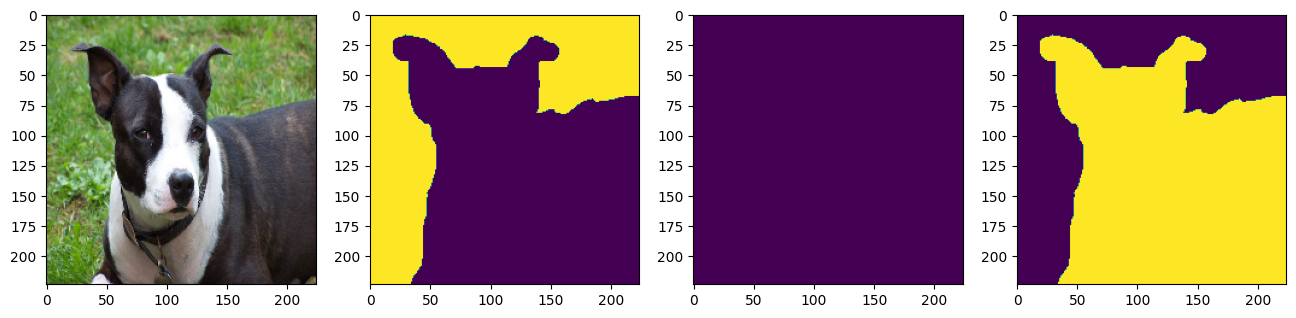

In [33]:
img,mask = loaded_valid_dataset.dataset[300]

img = (img+1.0) * 127.5
img = img/255

print(np.max(img),np.min(img))

fig, arr = plt.subplots(1,4, figsize=(16,5))
arr[0].imshow(img)
arr[1].imshow(mask[...,0])
arr[2].imshow(mask[...,1])
arr[3].imshow(mask[...,2])

### Prepare Callbacks

In [34]:
def saveModelCheckPoint():
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    file_name = f"test_best_model_trainable224-{timestamp}.h5"
    return str(file_name)

In [35]:
class plot_predict_per_epoch(tf.keras.callbacks.Callback):
    def __init__(self,model):
        super(plot_predict_per_epoch,self).__init__()
        self.model = model

    def on_epoch_end(self,epoch,logs=None):
      
        img,_ = loaded_valid_dataset.dataset[300]
        input_signature = np.expand_dims(img, axis=0)

        predict_mask = self.model.predict(input_signature)
        threshold = 0.5
        predict_mask = np.where(predict_mask>threshold,1,0)

        # remove -1,1 img normalization
        img = (img+1.0) * 127.5
        img = img/255

        fig,arr = plt.subplots(2,4)

        labels = ['img','bg','cat','dog']

        true_plot_list = [
            img,                         # Image
            mask[...,0].squeeze(),  # Background
            mask[...,1].squeeze(),  # Cat
            mask[...,2].squeeze()   # Dog
        ]

        predict_plot_list = [
            img,                         # Image
            predict_mask[...,0].squeeze(),  # Background
            predict_mask[...,1].squeeze(),  # Cat
            predict_mask[...,2].squeeze()   # Dog
        ]

        for i,arr_i in enumerate(arr):
            for j,arr_j in enumerate(arr_i):
                if i == 0:
                    arr_j.set_title(f"true_{labels[j]}")
                    arr_j.imshow(true_plot_list[j])
                    arr_j.axis('off')
                elif i == 1:
                    arr_j.set_title(f"predict_{labels[j]}")
                    arr_j.imshow(predict_plot_list[j])
                    arr_j.axis('off')

        mlflow.log_figure(fig,f'predict_plots/predict_plot_epoch_{epoch}.png')

        plt.show()

### Setup MLFlow

Epoch 1/50


2023-11-26 22:58:52.074338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 22:58:52.238954: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-26 22:58:52.238997: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-26 22:58:52.239111: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-26 22:58:53.255169: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory

290/413 [====================>.........] - ETA: 52s - loss: 0.5493 - IoU: 0.5248 - sensitivity: 0.6703 - specificity: 0.8397

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


333/413 [=======================>......] - ETA: 34s - loss: 0.5389 - IoU: 0.5431 - sensitivity: 0.6849 - specificity: 0.8465

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 1s 848ms/step loss: 0.5281 - IoU: 0.5583 - sensitivity: 0.6983 - specificity: 0.85


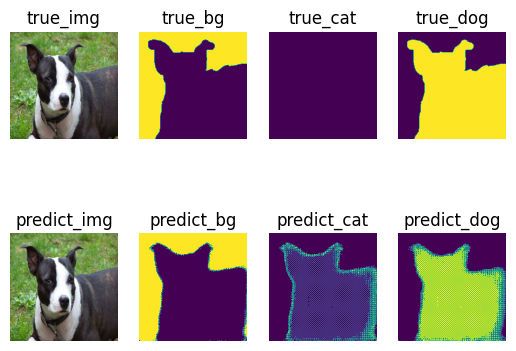

413/413 [==============================] - 214s 470ms/step - loss: 0.5281 - IoU: 0.5583 - sensitivity: 0.6983 - specificity: 0.8524 - val_loss: 0.4880 - val_IoU: 0.5954 - val_sensitivity: 0.7304 - val_specificity: 0.8656 - lr: 1.0000e-05
Epoch 2/50
101/413 [======>.......................] - ETA: 2:13 - loss: 0.4652 - IoU: 0.6537 - sensitivity: 0.7791 - specificity: 0.8898

Corrupt JPEG data: premature end of data segment


295/413 [====================>.........] - ETA: 50s - loss: 0.4605 - IoU: 0.6561 - sensitivity: 0.7829 - specificity: 0.8916

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 21ms/step- loss: 0.4576 - IoU: 0.6614 - sensitivity: 0.7873 - specificity: 0.89


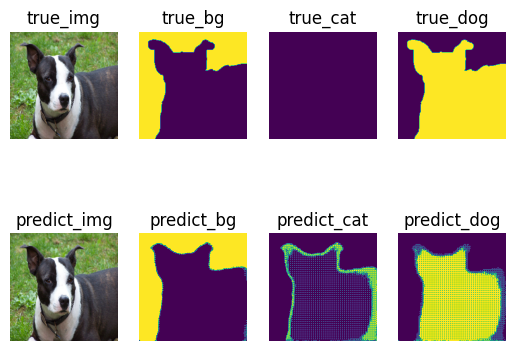

413/413 [==============================] - 192s 465ms/step - loss: 0.4576 - IoU: 0.6614 - sensitivity: 0.7873 - specificity: 0.8938 - val_loss: 0.4455 - val_IoU: 0.6676 - val_sensitivity: 0.7936 - val_specificity: 0.8968 - lr: 1.0000e-05
Epoch 3/50
193/413 [=============>................] - ETA: 1:34 - loss: 0.4398 - IoU: 0.6921 - sensitivity: 0.8120 - specificity: 0.9061

Corrupt JPEG data: premature end of data segment


359/413 [=========================>....] - ETA: 23s - loss: 0.4362 - IoU: 0.7022 - sensitivity: 0.8191 - specificity: 0.9096

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.4349 - IoU: 0.7058 - sensitivity: 0.8216 - specificity: 0.91


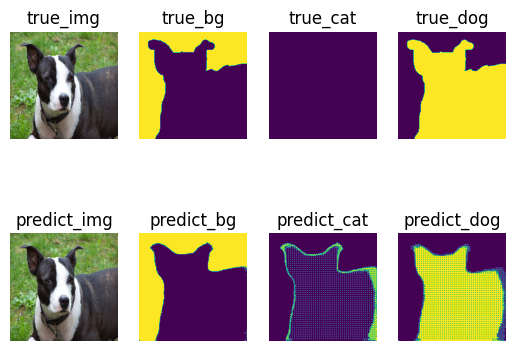

413/413 [==============================] - 194s 469ms/step - loss: 0.4349 - IoU: 0.7058 - sensitivity: 0.8216 - specificity: 0.9108 - val_loss: 0.4298 - val_IoU: 0.7160 - val_sensitivity: 0.8289 - val_specificity: 0.9145 - lr: 1.0000e-05
Epoch 4/50
111/413 [=======>......................] - ETA: 2:09 - loss: 0.4216 - IoU: 0.7418 - sensitivity: 0.8464 - specificity: 0.9232

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


155/413 [==========>...................] - ETA: 1:49 - loss: 0.4198 - IoU: 0.7445 - sensitivity: 0.8481 - specificity: 0.9241

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 20ms/step- loss: 0.4185 - IoU: 0.7521 - sensitivity: 0.8532 - specificity: 0.92


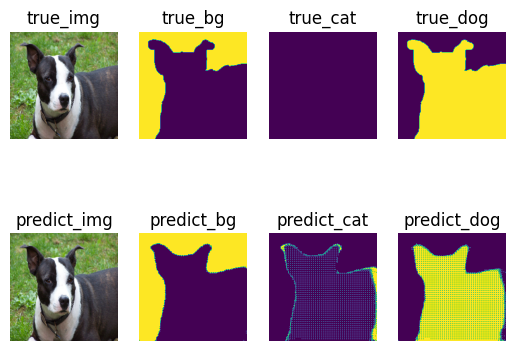

413/413 [==============================] - 192s 465ms/step - loss: 0.4185 - IoU: 0.7521 - sensitivity: 0.8532 - specificity: 0.9267 - val_loss: 0.4151 - val_IoU: 0.7844 - val_sensitivity: 0.8739 - val_specificity: 0.9370 - lr: 1.0000e-05
Epoch 5/50
118/413 [=======>......................] - ETA: 2:06 - loss: 0.4069 - IoU: 0.7957 - sensitivity: 0.8811 - specificity: 0.9406

Corrupt JPEG data: premature end of data segment


190/413 [============>.................] - ETA: 1:35 - loss: 0.4034 - IoU: 0.8079 - sensitivity: 0.8887 - specificity: 0.9444

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 20ms/step- loss: 0.3994 - IoU: 0.8239 - sensitivity: 0.8985 - specificity: 0.94


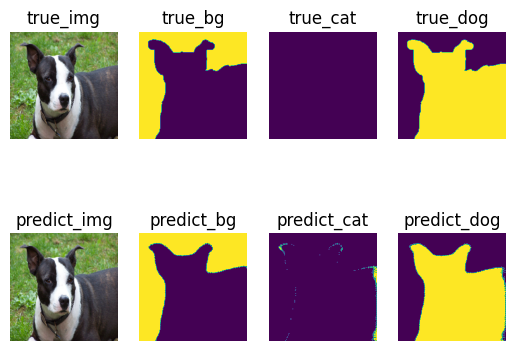

413/413 [==============================] - 190s 460ms/step - loss: 0.3994 - IoU: 0.8239 - sensitivity: 0.8985 - specificity: 0.9493 - val_loss: 0.3995 - val_IoU: 0.8343 - val_sensitivity: 0.9047 - val_specificity: 0.9524 - lr: 1.0000e-05
Epoch 6/50
 22/413 [>.............................] - ETA: 2:46 - loss: 0.3883 - IoU: 0.8547 - sensitivity: 0.9181 - specificity: 0.9591

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


321/413 [======================>.......] - ETA: 38s - loss: 0.3918 - IoU: 0.8506 - sensitivity: 0.9150 - specificity: 0.9576

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 23ms/step- loss: 0.3913 - IoU: 0.8521 - sensitivity: 0.9158 - specificity: 0.95


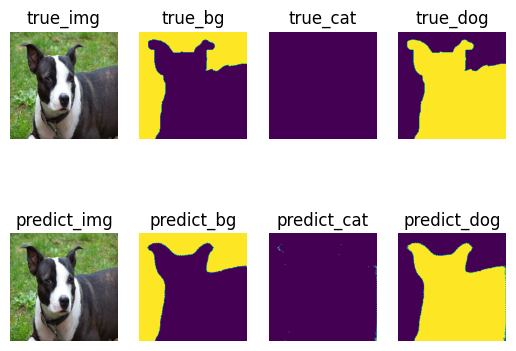

413/413 [==============================] - 191s 461ms/step - loss: 0.3913 - IoU: 0.8521 - sensitivity: 0.9158 - specificity: 0.9580 - val_loss: 0.4003 - val_IoU: 0.8344 - val_sensitivity: 0.9033 - val_specificity: 0.9517 - lr: 1.0000e-05
Epoch 7/50
 23/413 [>.............................] - ETA: 2:49 - loss: 0.3888 - IoU: 0.8576 - sensitivity: 0.9205 - specificity: 0.9603

Corrupt JPEG data: premature end of data segment


254/413 [=================>............] - ETA: 1:07 - loss: 0.3873 - IoU: 0.8643 - sensitivity: 0.9237 - specificity: 0.9619

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 21ms/step- loss: 0.3870 - IoU: 0.8653 - sensitivity: 0.9240 - specificity: 0.96


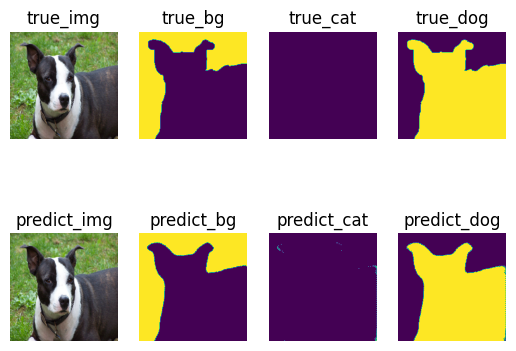

413/413 [==============================] - 191s 461ms/step - loss: 0.3870 - IoU: 0.8653 - sensitivity: 0.9240 - specificity: 0.9621 - val_loss: 0.3992 - val_IoU: 0.8356 - val_sensitivity: 0.9039 - val_specificity: 0.9520 - lr: 1.0000e-05
Epoch 8/50
119/413 [=======>......................] - ETA: 2:04 - loss: 0.3858 - IoU: 0.8691 - sensitivity: 0.9264 - specificity: 0.9632

Corrupt JPEG data: premature end of data segment


148/413 [=========>....................] - ETA: 1:52 - loss: 0.3854 - IoU: 0.8703 - sensitivity: 0.9271 - specificity: 0.9636

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 21ms/step- loss: 0.3838 - IoU: 0.8743 - sensitivity: 0.9295 - specificity: 0.96


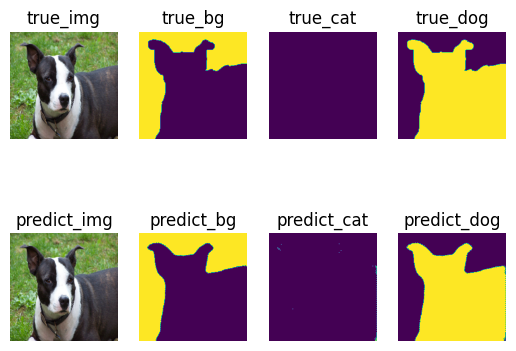

413/413 [==============================] - 190s 459ms/step - loss: 0.3838 - IoU: 0.8743 - sensitivity: 0.9295 - specificity: 0.9648 - val_loss: 0.3909 - val_IoU: 0.8612 - val_sensitivity: 0.9207 - val_specificity: 0.9604 - lr: 1.0000e-05
Epoch 9/50
193/413 [=============>................] - ETA: 1:32 - loss: 0.3791 - IoU: 0.8854 - sensitivity: 0.9365 - specificity: 0.9683

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


333/413 [=======================>......] - ETA: 33s - loss: 0.3792 - IoU: 0.8855 - sensitivity: 0.9365 - specificity: 0.9683

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 21ms/step- loss: 0.3801 - IoU: 0.8836 - sensitivity: 0.9353 - specificity: 0.96


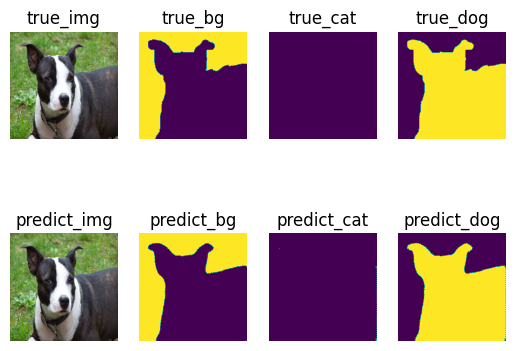

413/413 [==============================] - 190s 459ms/step - loss: 0.3801 - IoU: 0.8836 - sensitivity: 0.9353 - specificity: 0.9677 - val_loss: 0.3892 - val_IoU: 0.8693 - val_sensitivity: 0.9256 - val_specificity: 0.9628 - lr: 1.0000e-05
Epoch 10/50
118/413 [=======>......................] - ETA: 2:06 - loss: 0.3756 - IoU: 0.8930 - sensitivity: 0.9414 - specificity: 0.9708

Corrupt JPEG data: premature end of data segment


233/413 [===============>..............] - ETA: 1:17 - loss: 0.3762 - IoU: 0.8926 - sensitivity: 0.9410 - specificity: 0.9706

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 26ms/step- loss: 0.3777 - IoU: 0.8901 - sensitivity: 0.9393 - specificity: 0.96


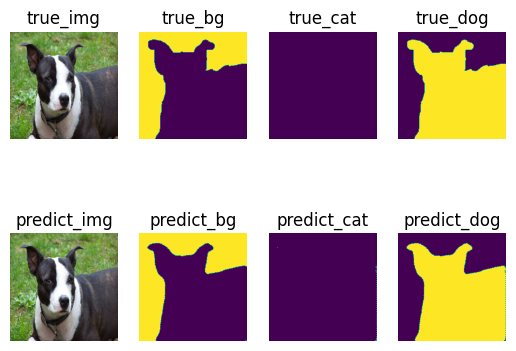

413/413 [==============================] - 193s 466ms/step - loss: 0.3777 - IoU: 0.8901 - sensitivity: 0.9393 - specificity: 0.9697 - val_loss: 0.3888 - val_IoU: 0.8725 - val_sensitivity: 0.9275 - val_specificity: 0.9638 - lr: 1.0000e-05
Epoch 11/50
  7/413 [..............................] - ETA: 2:56 - loss: 0.3718 - IoU: 0.9038 - sensitivity: 0.9478 - specificity: 0.9739

Corrupt JPEG data: premature end of data segment


281/413 [===================>..........] - ETA: 55s - loss: 0.3749 - IoU: 0.8976 - sensitivity: 0.9438 - specificity: 0.9719

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 24ms/step- loss: 0.3749 - IoU: 0.8975 - sensitivity: 0.9438 - specificity: 0.97


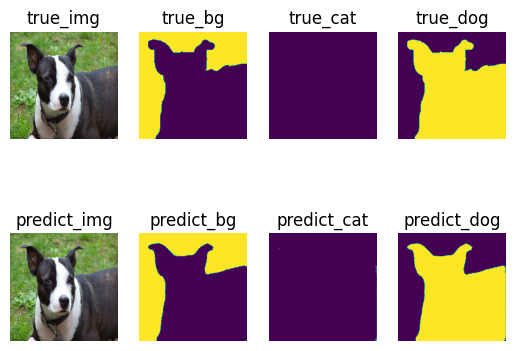

413/413 [==============================] - 191s 461ms/step - loss: 0.3749 - IoU: 0.8975 - sensitivity: 0.9438 - specificity: 0.9719 - val_loss: 0.3914 - val_IoU: 0.8687 - val_sensitivity: 0.9252 - val_specificity: 0.9626 - lr: 1.0000e-05
Epoch 12/50
159/413 [==========>...................] - ETA: 1:47 - loss: 0.3737 - IoU: 0.9019 - sensitivity: 0.9462 - specificity: 0.9731

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


197/413 [=============>................] - ETA: 1:31 - loss: 0.3731 - IoU: 0.9031 - sensitivity: 0.9470 - specificity: 0.9735

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 25ms/step- loss: 0.3740 - IoU: 0.8998 - sensitivity: 0.9451 - specificity: 0.97


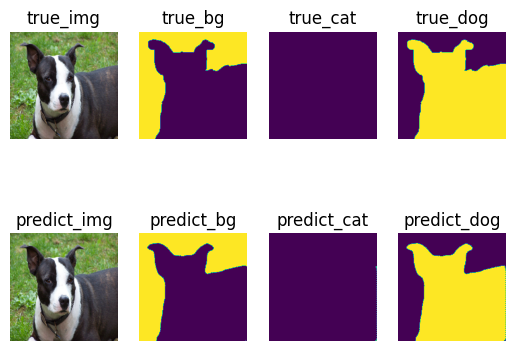

413/413 [==============================] - 191s 463ms/step - loss: 0.3740 - IoU: 0.8998 - sensitivity: 0.9451 - specificity: 0.9726 - val_loss: 0.3912 - val_IoU: 0.8694 - val_sensitivity: 0.9246 - val_specificity: 0.9623 - lr: 1.0000e-05
Epoch 13/50
248/413 [=================>............] - ETA: 1:09 - loss: 0.3726 - IoU: 0.9039 - sensitivity: 0.9475 - specificity: 0.9738

Corrupt JPEG data: premature end of data segment


297/413 [====================>.........] - ETA: 48s - loss: 0.3724 - IoU: 0.9043 - sensitivity: 0.9478 - specificity: 0.9739

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 24ms/step- loss: 0.3720 - IoU: 0.9054 - sensitivity: 0.9484 - specificity: 0.97


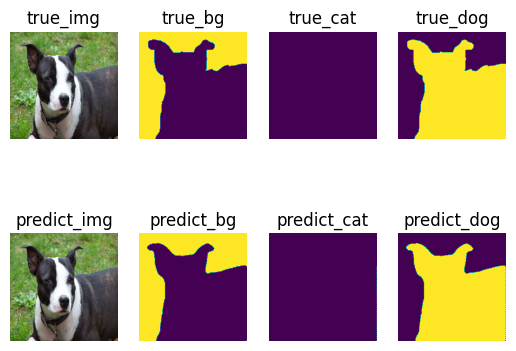

413/413 [==============================] - 190s 459ms/step - loss: 0.3720 - IoU: 0.9054 - sensitivity: 0.9484 - specificity: 0.9742 - val_loss: 0.3867 - val_IoU: 0.8791 - val_sensitivity: 0.9308 - val_specificity: 0.9654 - lr: 1.0000e-05
Epoch 14/50
253/413 [=================>............] - ETA: 1:08 - loss: 0.3706 - IoU: 0.9091 - sensitivity: 0.9506 - specificity: 0.9753

Corrupt JPEG data: premature end of data segment


385/413 [==========================>...] - ETA: 11s - loss: 0.3704 - IoU: 0.9093 - sensitivity: 0.9508 - specificity: 0.9754

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.3705 - IoU: 0.9091 - sensitivity: 0.9506 - specificity: 0.97


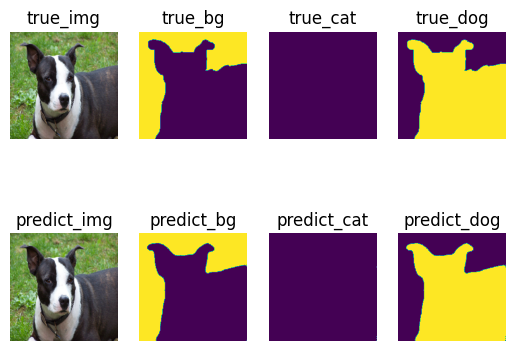

413/413 [==============================] - 193s 466ms/step - loss: 0.3705 - IoU: 0.9091 - sensitivity: 0.9506 - specificity: 0.9753 - val_loss: 0.3854 - val_IoU: 0.8810 - val_sensitivity: 0.9321 - val_specificity: 0.9661 - lr: 1.0000e-05
Epoch 15/50
 68/413 [===>..........................] - ETA: 2:34 - loss: 0.3693 - IoU: 0.9137 - sensitivity: 0.9527 - specificity: 0.9764

Corrupt JPEG data: premature end of data segment


155/413 [==========>...................] - ETA: 1:51 - loss: 0.3687 - IoU: 0.9144 - sensitivity: 0.9536 - specificity: 0.9768

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 25ms/step- loss: 0.3678 - IoU: 0.9155 - sensitivity: 0.9544 - specificity: 0.97


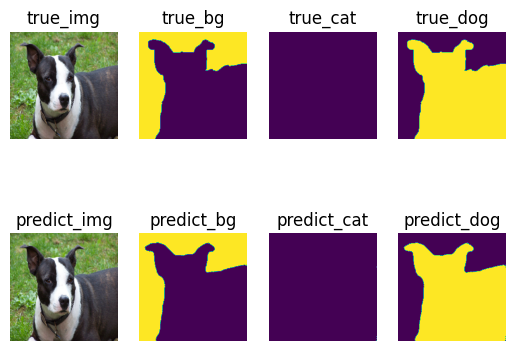

413/413 [==============================] - 193s 467ms/step - loss: 0.3678 - IoU: 0.9155 - sensitivity: 0.9544 - specificity: 0.9772 - val_loss: 0.3865 - val_IoU: 0.8806 - val_sensitivity: 0.9322 - val_specificity: 0.9661 - lr: 1.0000e-05
Epoch 16/50
126/413 [========>.....................] - ETA: 2:02 - loss: 0.3710 - IoU: 0.9068 - sensitivity: 0.9491 - specificity: 0.9746

Corrupt JPEG data: premature end of data segment


336/413 [=======================>......] - ETA: 32s - loss: 0.3678 - IoU: 0.9158 - sensitivity: 0.9545 - specificity: 0.9772

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 32ms/step- loss: 0.3677 - IoU: 0.9160 - sensitivity: 0.9546 - specificity: 0.97


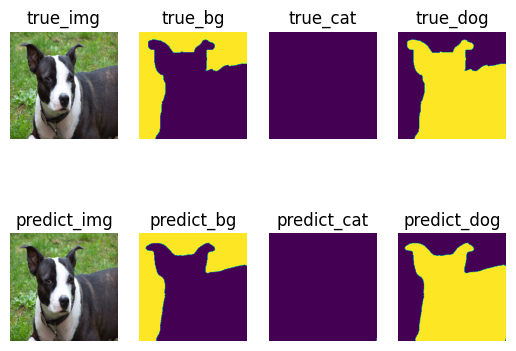

413/413 [==============================] - 192s 464ms/step - loss: 0.3677 - IoU: 0.9160 - sensitivity: 0.9546 - specificity: 0.9773 - val_loss: 0.3868 - val_IoU: 0.8811 - val_sensitivity: 0.9323 - val_specificity: 0.9662 - lr: 1.0000e-05
Epoch 17/50
118/413 [=======>......................] - ETA: 2:08 - loss: 0.3646 - IoU: 0.9245 - sensitivity: 0.9598 - specificity: 0.9799

Corrupt JPEG data: premature end of data segment


246/413 [================>.............] - ETA: 1:11 - loss: 0.3649 - IoU: 0.9233 - sensitivity: 0.9589 - specificity: 0.9795

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 34ms/step- loss: 0.3666 - IoU: 0.9190 - sensitivity: 0.9563 - specificity: 0.97


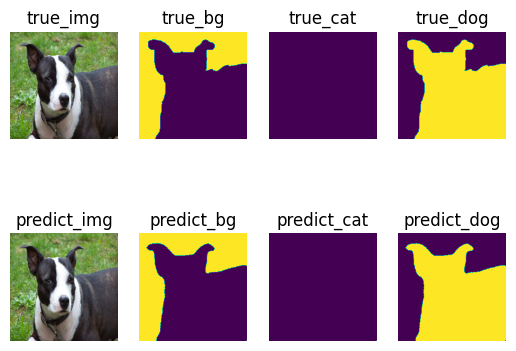

413/413 [==============================] - 192s 465ms/step - loss: 0.3666 - IoU: 0.9190 - sensitivity: 0.9563 - specificity: 0.9782 - val_loss: 0.3847 - val_IoU: 0.8862 - val_sensitivity: 0.9354 - val_specificity: 0.9677 - lr: 1.0000e-05
Epoch 18/50
  7/413 [..............................] - ETA: 3:01 - loss: 0.3610 - IoU: 0.9324 - sensitivity: 0.9644 - specificity: 0.9822

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 80/413 [====>.........................] - ETA: 2:21 - loss: 0.3656 - IoU: 0.9222 - sensitivity: 0.9579 - specificity: 0.9790

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 25ms/step- loss: 0.3658 - IoU: 0.9209 - sensitivity: 0.9575 - specificity: 0.97


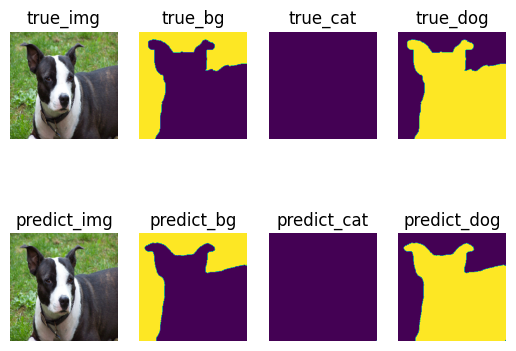

413/413 [==============================] - 194s 468ms/step - loss: 0.3658 - IoU: 0.9209 - sensitivity: 0.9575 - specificity: 0.9787 - val_loss: 0.3829 - val_IoU: 0.8880 - val_sensitivity: 0.9366 - val_specificity: 0.9683 - lr: 1.0000e-05
Epoch 19/50
110/413 [======>.......................] - ETA: 2:09 - loss: 0.3642 - IoU: 0.9259 - sensitivity: 0.9599 - specificity: 0.9799

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


147/413 [=========>....................] - ETA: 1:55 - loss: 0.3638 - IoU: 0.9265 - sensitivity: 0.9604 - specificity: 0.9802

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.3635 - IoU: 0.9270 - sensitivity: 0.9610 - specificity: 0.98


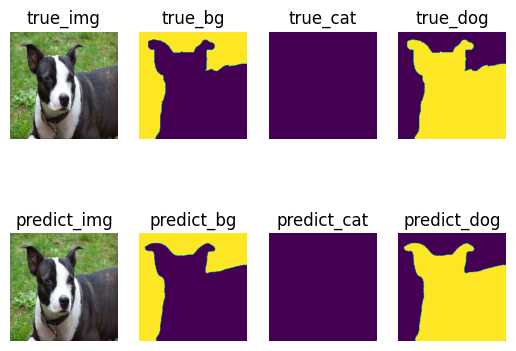

413/413 [==============================] - 195s 471ms/step - loss: 0.3635 - IoU: 0.9270 - sensitivity: 0.9610 - specificity: 0.9805 - val_loss: 0.3842 - val_IoU: 0.8851 - val_sensitivity: 0.9346 - val_specificity: 0.9673 - lr: 1.0000e-05
Epoch 20/50
161/413 [==========>...................] - ETA: 1:46 - loss: 0.3623 - IoU: 0.9302 - sensitivity: 0.9629 - specificity: 0.9815

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


299/413 [====================>.........] - ETA: 48s - loss: 0.3626 - IoU: 0.9294 - sensitivity: 0.9625 - specificity: 0.9812

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.3625 - IoU: 0.9294 - sensitivity: 0.9624 - specificity: 0.98


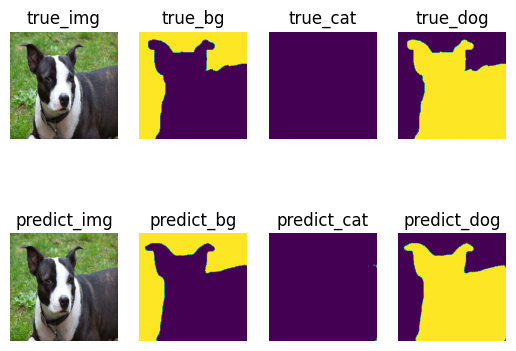

413/413 [==============================] - 193s 467ms/step - loss: 0.3625 - IoU: 0.9294 - sensitivity: 0.9624 - specificity: 0.9812 - val_loss: 0.3903 - val_IoU: 0.8721 - val_sensitivity: 0.9261 - val_specificity: 0.9631 - lr: 1.0000e-05
Epoch 21/50
 55/413 [==>...........................] - ETA: 2:31 - loss: 0.3671 - IoU: 0.9187 - sensitivity: 0.9556 - specificity: 0.9778

Corrupt JPEG data: premature end of data segment


315/413 [=====================>........] - ETA: 41s - loss: 0.3628 - IoU: 0.9288 - sensitivity: 0.9619 - specificity: 0.9810

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.3623 - IoU: 0.9300 - sensitivity: 0.9627 - specificity: 0.98


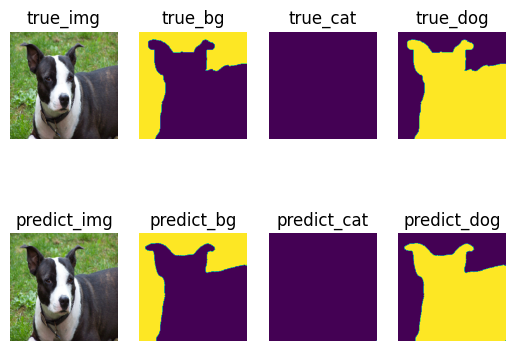

413/413 [==============================] - 193s 465ms/step - loss: 0.3623 - IoU: 0.9300 - sensitivity: 0.9627 - specificity: 0.9814 - val_loss: 0.3831 - val_IoU: 0.8890 - val_sensitivity: 0.9370 - val_specificity: 0.9685 - lr: 1.0000e-05
Epoch 22/50
 28/413 [=>............................] - ETA: 2:45 - loss: 0.3609 - IoU: 0.9330 - sensitivity: 0.9641 - specificity: 0.9821

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


159/413 [==========>...................] - ETA: 1:46 - loss: 0.3619 - IoU: 0.9300 - sensitivity: 0.9627 - specificity: 0.9814

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.3613 - IoU: 0.9323 - sensitivity: 0.9641 - specificity: 0.98


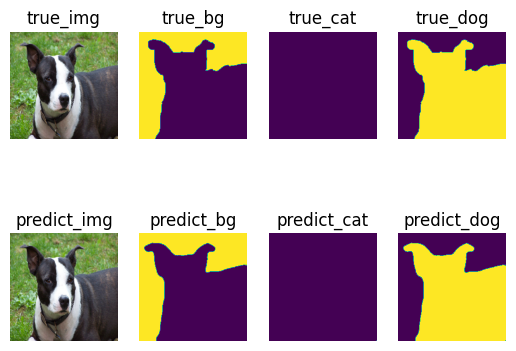

413/413 [==============================] - 190s 459ms/step - loss: 0.3613 - IoU: 0.9323 - sensitivity: 0.9641 - specificity: 0.9820 - val_loss: 0.3821 - val_IoU: 0.8913 - val_sensitivity: 0.9385 - val_specificity: 0.9693 - lr: 1.0000e-05
Epoch 23/50
284/413 [===================>..........] - ETA: 54s - loss: 0.3600 - IoU: 0.9356 - sensitivity: 0.9659 - specificity: 0.9830

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


299/413 [====================>.........] - ETA: 47s - loss: 0.3601 - IoU: 0.9353 - sensitivity: 0.9658 - specificity: 0.9829

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.3607 - IoU: 0.9339 - sensitivity: 0.9649 - specificity: 0.98


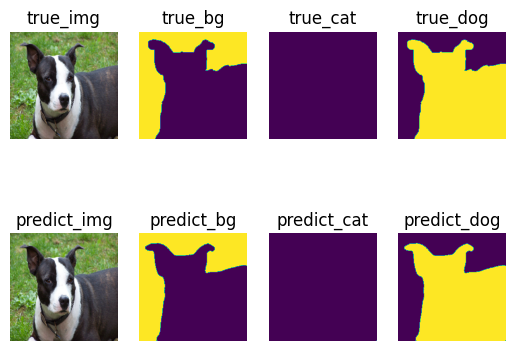

413/413 [==============================] - 190s 460ms/step - loss: 0.3607 - IoU: 0.9339 - sensitivity: 0.9649 - specificity: 0.9825 - val_loss: 0.3838 - val_IoU: 0.8897 - val_sensitivity: 0.9376 - val_specificity: 0.9688 - lr: 1.0000e-05
Epoch 24/50
 78/413 [====>.........................] - ETA: 2:23 - loss: 0.3601 - IoU: 0.9361 - sensitivity: 0.9660 - specificity: 0.9830

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


199/413 [=============>................] - ETA: 1:30 - loss: 0.3591 - IoU: 0.9380 - sensitivity: 0.9673 - specificity: 0.9836

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 23ms/step- loss: 0.3594 - IoU: 0.9373 - sensitivity: 0.9668 - specificity: 0.98


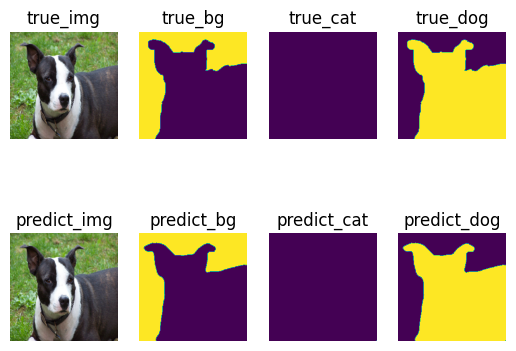

413/413 [==============================] - 192s 463ms/step - loss: 0.3594 - IoU: 0.9373 - sensitivity: 0.9668 - specificity: 0.9834 - val_loss: 0.3819 - val_IoU: 0.8922 - val_sensitivity: 0.9389 - val_specificity: 0.9695 - lr: 1.0000e-05
Epoch 25/50
334/413 [=======================>......] - ETA: 33s - loss: 0.3595 - IoU: 0.9368 - sensitivity: 0.9666 - specificity: 0.9833

Corrupt JPEG data: premature end of data segment


352/413 [========================>.....] - ETA: 25s - loss: 0.3596 - IoU: 0.9368 - sensitivity: 0.9666 - specificity: 0.9833

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 29ms/step- loss: 0.3598 - IoU: 0.9364 - sensitivity: 0.9663 - specificity: 0.98


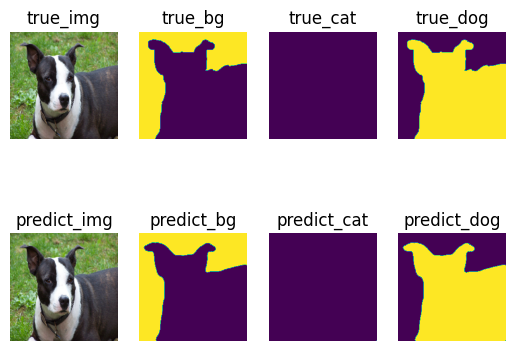

413/413 [==============================] - 192s 463ms/step - loss: 0.3598 - IoU: 0.9364 - sensitivity: 0.9663 - specificity: 0.9832 - val_loss: 0.3826 - val_IoU: 0.8931 - val_sensitivity: 0.9394 - val_specificity: 0.9697 - lr: 1.0000e-05
Epoch 26/50
  1/413 [..............................] - ETA: 6:24 - loss: 0.3530 - IoU: 0.9522 - sensitivity: 0.9755 - specificity: 0.9878

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


403/413 [============================>.] - ETA: 4s - loss: 0.3587 - IoU: 0.9389 - sensitivity: 0.9678 - specificity: 0.9839

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.3587 - IoU: 0.9389 - sensitivity: 0.9678 - specificity: 0.98


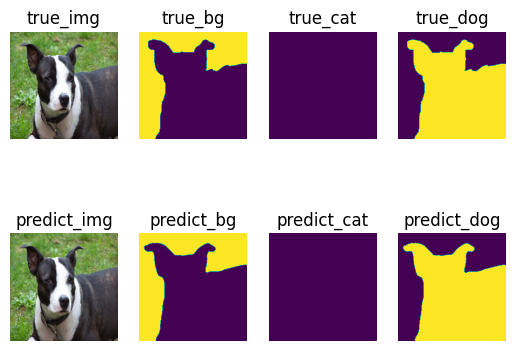

413/413 [==============================] - 192s 464ms/step - loss: 0.3587 - IoU: 0.9389 - sensitivity: 0.9678 - specificity: 0.9839 - val_loss: 0.3822 - val_IoU: 0.8931 - val_sensitivity: 0.9396 - val_specificity: 0.9698 - lr: 1.0000e-05
Epoch 27/50
 39/413 [=>............................] - ETA: 2:43 - loss: 0.3581 - IoU: 0.9405 - sensitivity: 0.9683 - specificity: 0.9842

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


282/413 [===================>..........] - ETA: 56s - loss: 0.3578 - IoU: 0.9414 - sensitivity: 0.9691 - specificity: 0.9846

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.3575 - IoU: 0.9420 - sensitivity: 0.9695 - specificity: 0.98


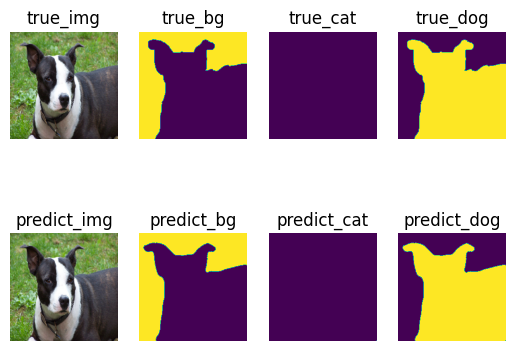

413/413 [==============================] - 194s 468ms/step - loss: 0.3575 - IoU: 0.9420 - sensitivity: 0.9695 - specificity: 0.9848 - val_loss: 0.3825 - val_IoU: 0.8921 - val_sensitivity: 0.9389 - val_specificity: 0.9694 - lr: 1.0000e-05
Epoch 28/50
322/413 [======================>.......] - ETA: 39s - loss: 0.3570 - IoU: 0.9434 - sensitivity: 0.9702 - specificity: 0.9851

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


407/413 [============================>.] - ETA: 2s - loss: 0.3570 - IoU: 0.9434 - sensitivity: 0.9702 - specificity: 0.9851

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 53ms/step- loss: 0.3570 - IoU: 0.9434 - sensitivity: 0.9703 - specificity: 0.98


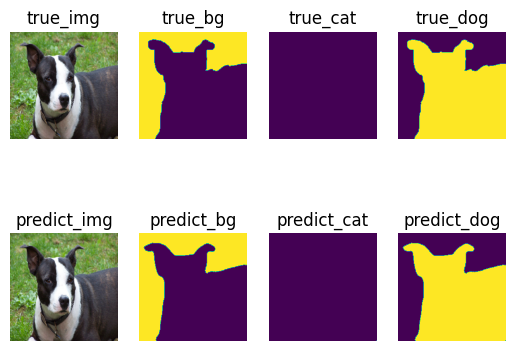

413/413 [==============================] - 194s 469ms/step - loss: 0.3570 - IoU: 0.9434 - sensitivity: 0.9703 - specificity: 0.9851 - val_loss: 0.3830 - val_IoU: 0.8930 - val_sensitivity: 0.9395 - val_specificity: 0.9698 - lr: 1.0000e-05
Epoch 29/50
264/413 [==================>...........] - ETA: 1:03 - loss: 0.3569 - IoU: 0.9437 - sensitivity: 0.9705 - specificity: 0.9852

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


289/413 [===================>..........] - ETA: 52s - loss: 0.3569 - IoU: 0.9438 - sensitivity: 0.9705 - specificity: 0.9853

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.3567 - IoU: 0.9440 - sensitivity: 0.9706 - specificity: 0.98


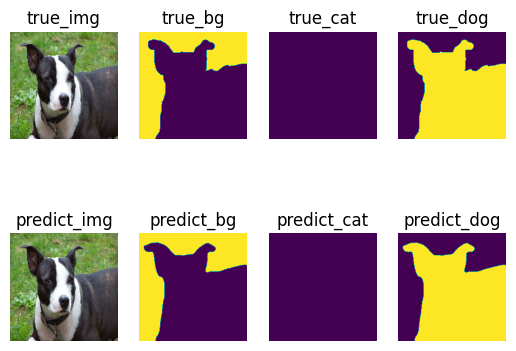

413/413 [==============================] - 190s 460ms/step - loss: 0.3567 - IoU: 0.9440 - sensitivity: 0.9706 - specificity: 0.9853 - val_loss: 0.3838 - val_IoU: 0.8900 - val_sensitivity: 0.9378 - val_specificity: 0.9689 - lr: 1.0000e-05
Epoch 30/50
 92/413 [=====>........................] - ETA: 2:15 - loss: 0.3558 - IoU: 0.9460 - sensitivity: 0.9716 - specificity: 0.9858

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


284/413 [===================>..........] - ETA: 54s - loss: 0.3562 - IoU: 0.9451 - sensitivity: 0.9712 - specificity: 0.9856

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 26ms/step- loss: 0.3561 - IoU: 0.9452 - sensitivity: 0.9713 - specificity: 0.98


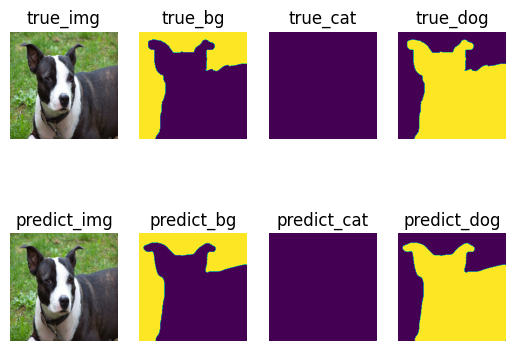

413/413 [==============================] - 191s 461ms/step - loss: 0.3561 - IoU: 0.9452 - sensitivity: 0.9713 - specificity: 0.9856 - val_loss: 0.3824 - val_IoU: 0.8908 - val_sensitivity: 0.9381 - val_specificity: 0.9691 - lr: 1.0000e-05
Epoch 31/50
255/413 [=================>............] - ETA: 1:08 - loss: 0.3585 - IoU: 0.9398 - sensitivity: 0.9682 - specificity: 0.9841

Corrupt JPEG data: premature end of data segment


281/413 [===================>..........] - ETA: 57s - loss: 0.3584 - IoU: 0.9402 - sensitivity: 0.9684 - specificity: 0.9842

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.3594 - IoU: 0.9376 - sensitivity: 0.9666 - specificity: 0.98


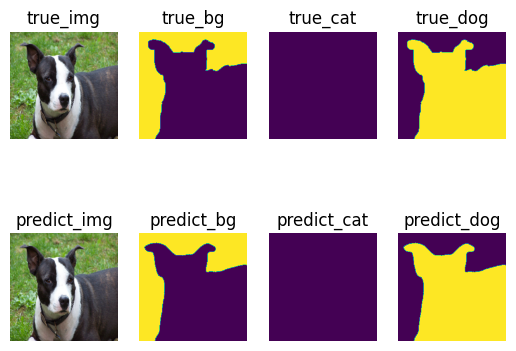

413/413 [==============================] - 193s 467ms/step - loss: 0.3594 - IoU: 0.9376 - sensitivity: 0.9666 - specificity: 0.9833 - val_loss: 0.3907 - val_IoU: 0.8723 - val_sensitivity: 0.9259 - val_specificity: 0.9630 - lr: 1.0000e-05
Epoch 32/50
 95/413 [=====>........................] - ETA: 2:14 - loss: 0.3621 - IoU: 0.9294 - sensitivity: 0.9617 - specificity: 0.9808

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


117/413 [=======>......................] - ETA: 2:04 - loss: 0.3607 - IoU: 0.9328 - sensitivity: 0.9638 - specificity: 0.9819

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 25ms/step- loss: 0.3577 - IoU: 0.9409 - sensitivity: 0.9686 - specificity: 0.98


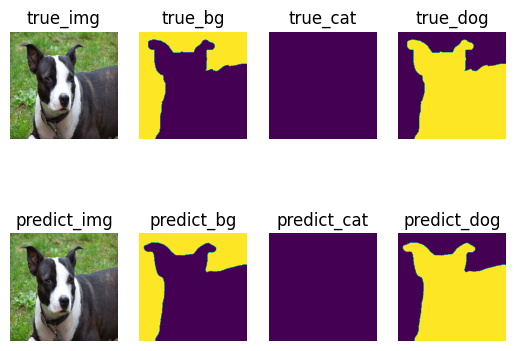

413/413 [==============================] - 192s 464ms/step - loss: 0.3577 - IoU: 0.9409 - sensitivity: 0.9686 - specificity: 0.9843 - val_loss: 0.3815 - val_IoU: 0.8928 - val_sensitivity: 0.9392 - val_specificity: 0.9696 - lr: 1.0000e-05
Epoch 33/50
191/413 [============>.................] - ETA: 1:34 - loss: 0.2449 - IoU: 0.8010 - sensitivity: 0.8649 - specificity: 0.9324

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


310/413 [=====================>........] - ETA: 43s - loss: 0.2379 - IoU: 0.7890 - sensitivity: 0.8541 - specificity: 0.9270

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 23ms/step- loss: 0.2342 - IoU: 0.7854 - sensitivity: 0.8504 - specificity: 0.92


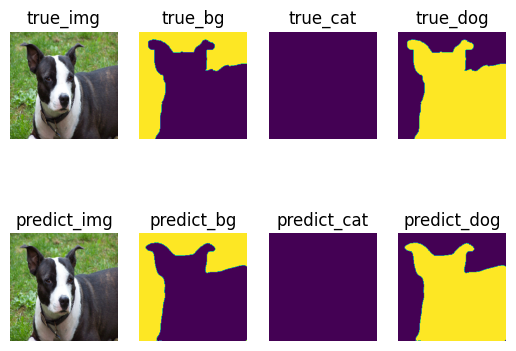

413/413 [==============================] - 191s 461ms/step - loss: 0.2342 - IoU: 0.7854 - sensitivity: 0.8504 - specificity: 0.9252 - val_loss: 0.2566 - val_IoU: 0.7298 - val_sensitivity: 0.8074 - val_specificity: 0.9037 - lr: 1.0000e-05
Epoch 34/50
180/413 [============>.................] - ETA: 1:39 - loss: 0.2616 - IoU: 0.7417 - sensitivity: 0.8127 - specificity: 0.9064

Corrupt JPEG data: premature end of data segment


308/413 [=====================>........] - ETA: 44s - loss: 0.2414 - IoU: 0.7600 - sensitivity: 0.8274 - specificity: 0.9137

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 21ms/step- loss: 0.2352 - IoU: 0.7645 - sensitivity: 0.8306 - specificity: 0.91


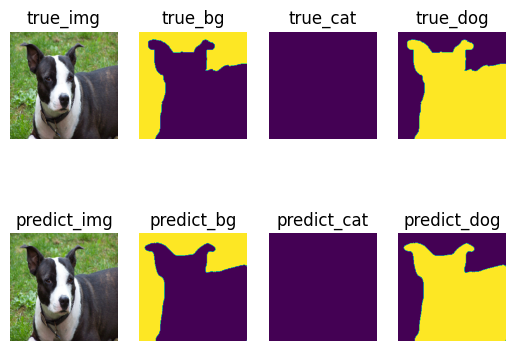

413/413 [==============================] - 190s 460ms/step - loss: 0.2352 - IoU: 0.7645 - sensitivity: 0.8306 - specificity: 0.9153 - val_loss: 0.2540 - val_IoU: 0.7314 - val_sensitivity: 0.8066 - val_specificity: 0.9033 - lr: 1.0000e-05
Epoch 35/50
 54/413 [==>...........................] - ETA: 2:31 - loss: 0.1920 - IoU: 0.8048 - sensitivity: 0.8613 - specificity: 0.9306

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


374/413 [==========================>...] - ETA: 16s - loss: 0.2243 - IoU: 0.7742 - sensitivity: 0.8377 - specificity: 0.9188

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 22ms/step- loss: 0.2337 - IoU: 0.7689 - sensitivity: 0.8342 - specificity: 0.91


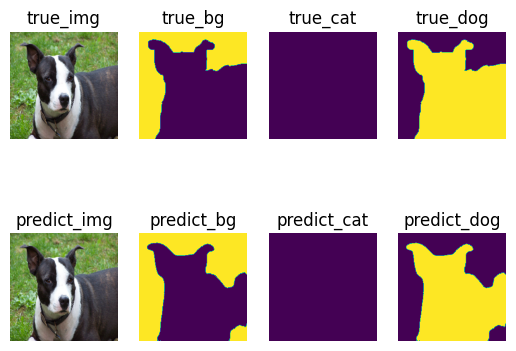

413/413 [==============================] - 188s 455ms/step - loss: 0.2337 - IoU: 0.7689 - sensitivity: 0.8342 - specificity: 0.9171 - val_loss: 0.2683 - val_IoU: 0.7672 - val_sensitivity: 0.8579 - val_specificity: 0.9289 - lr: 1.0000e-05
Epoch 36/50
232/413 [===============>..............] - ETA: 1:17 - loss: 0.2163 - IoU: 0.7925 - sensitivity: 0.8669 - specificity: 0.9335

Corrupt JPEG data: premature end of data segment


323/413 [======================>.......] - ETA: 38s - loss: 0.1867 - IoU: 0.8158 - sensitivity: 0.8841 - specificity: 0.9421

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 21ms/step- loss: 0.1680 - IoU: 0.8311 - sensitivity: 0.8951 - specificity: 0.94


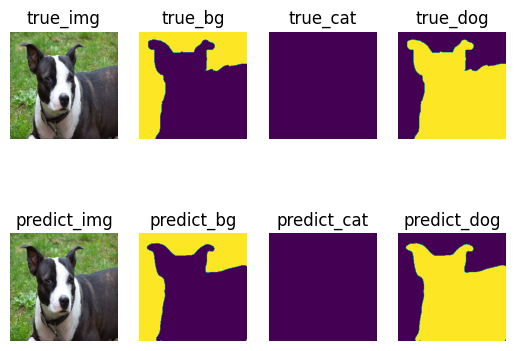

413/413 [==============================] - 194s 469ms/step - loss: 0.1680 - IoU: 0.8311 - sensitivity: 0.8951 - specificity: 0.9476 - val_loss: 0.1216 - val_IoU: 0.8615 - val_sensitivity: 0.9188 - val_specificity: 0.9594 - lr: 1.0000e-05
Epoch 37/50
134/413 [========>.....................] - ETA: 2:01 - loss: 0.1015 - IoU: 0.8905 - sensitivity: 0.9386 - specificity: 0.9693

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


339/413 [=======================>......] - ETA: 31s - loss: 0.1502 - IoU: 0.8418 - sensitivity: 0.9055 - specificity: 0.9527

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 21ms/step- loss: 0.1526 - IoU: 0.8374 - sensitivity: 0.9009 - specificity: 0.95


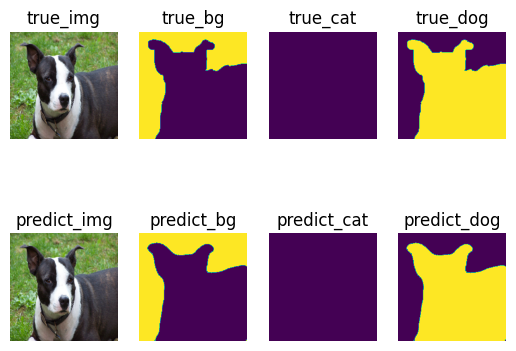

413/413 [==============================] - 193s 466ms/step - loss: 0.1526 - IoU: 0.8374 - sensitivity: 0.9009 - specificity: 0.9504 - val_loss: 0.2461 - val_IoU: 0.7378 - val_sensitivity: 0.8171 - val_specificity: 0.9086 - lr: 1.0000e-05
Epoch 38/50
168/413 [===========>..................] - ETA: 1:44 - loss: 0.1857 - IoU: 0.8071 - sensitivity: 0.8731 - specificity: 0.9366

Corrupt JPEG data: premature end of data segment


222/413 [===============>..............] - ETA: 1:21 - loss: 0.1657 - IoU: 0.8254 - sensitivity: 0.8872 - specificity: 0.9436

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.1313 - IoU: 0.8587 - sensitivity: 0.9125 - specificity: 0.95


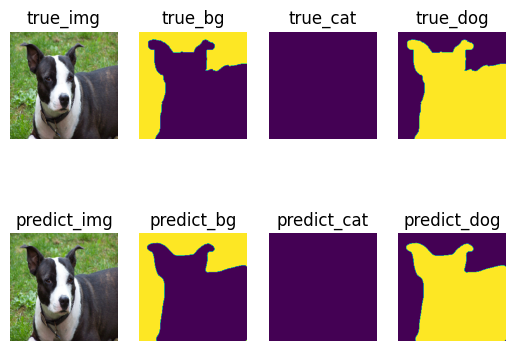

413/413 [==============================] - 193s 466ms/step - loss: 0.1313 - IoU: 0.8587 - sensitivity: 0.9125 - specificity: 0.9563 - val_loss: 0.1292 - val_IoU: 0.8589 - val_sensitivity: 0.9171 - val_specificity: 0.9586 - lr: 1.0000e-05
Epoch 39/50
177/413 [===========>..................] - ETA: 1:40 - loss: 0.1339 - IoU: 0.8697 - sensitivity: 0.9235 - specificity: 0.9618

Corrupt JPEG data: premature end of data segment


286/413 [===================>..........] - ETA: 54s - loss: 0.1566 - IoU: 0.8406 - sensitivity: 0.8990 - specificity: 0.9495

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.1774 - IoU: 0.8241 - sensitivity: 0.8859 - specificity: 0.94


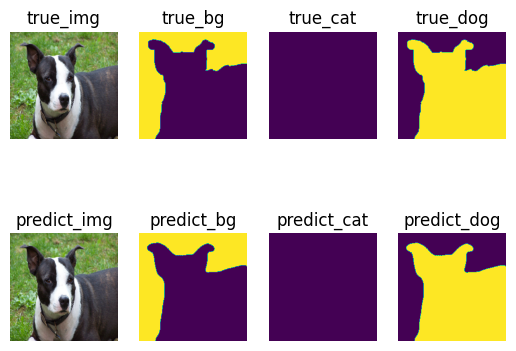

413/413 [==============================] - 193s 466ms/step - loss: 0.1774 - IoU: 0.8241 - sensitivity: 0.8859 - specificity: 0.9430 - val_loss: 0.1891 - val_IoU: 0.8142 - val_sensitivity: 0.8812 - val_specificity: 0.9406 - lr: 1.0000e-05
Epoch 40/50
 96/413 [=====>........................] - ETA: 2:15 - loss: 0.1130 - IoU: 0.8673 - sensitivity: 0.9227 - specificity: 0.9614

Corrupt JPEG data: premature end of data segment


100/413 [======>.......................] - ETA: 2:13 - loss: 0.1134 - IoU: 0.8673 - sensitivity: 0.9227 - specificity: 0.9614

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 25ms/step- loss: 0.0978 - IoU: 0.8799 - sensitivity: 0.9317 - specificity: 0.96


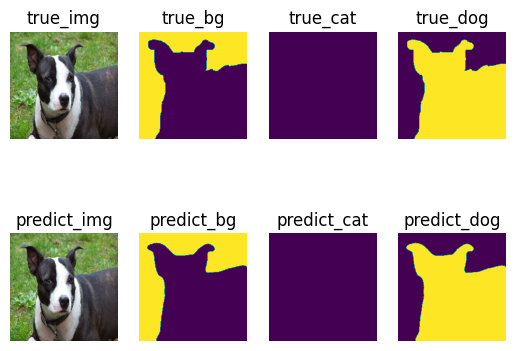

413/413 [==============================] - 193s 466ms/step - loss: 0.0978 - IoU: 0.8799 - sensitivity: 0.9317 - specificity: 0.9659 - val_loss: 0.1067 - val_IoU: 0.8741 - val_sensitivity: 0.9279 - val_specificity: 0.9639 - lr: 1.0000e-05
Epoch 41/50
305/413 [=====================>........] - ETA: 45s - loss: 0.0807 - IoU: 0.9067 - sensitivity: 0.9483 - specificity: 0.9741

Corrupt JPEG data: premature end of data segment


347/413 [========================>.....] - ETA: 28s - loss: 0.0797 - IoU: 0.9080 - sensitivity: 0.9491 - specificity: 0.9745

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 21ms/step- loss: 0.0812 - IoU: 0.9032 - sensitivity: 0.9462 - specificity: 0.97


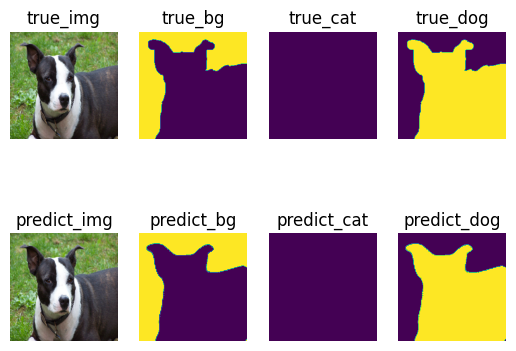

413/413 [==============================] - 193s 466ms/step - loss: 0.0812 - IoU: 0.9032 - sensitivity: 0.9462 - specificity: 0.9731 - val_loss: 0.1644 - val_IoU: 0.8016 - val_sensitivity: 0.8762 - val_specificity: 0.9381 - lr: 1.0000e-05
Epoch 42/50
137/413 [========>.....................] - ETA: 1:57 - loss: 0.1418 - IoU: 0.8409 - sensitivity: 0.9018 - specificity: 0.9509

Corrupt JPEG data: premature end of data segment


270/413 [==================>...........] - ETA: 1:00 - loss: 0.1136 - IoU: 0.8697 - sensitivity: 0.9228 - specificity: 0.9614

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 24ms/step- loss: 0.1025 - IoU: 0.8738 - sensitivity: 0.9261 - specificity: 0.96


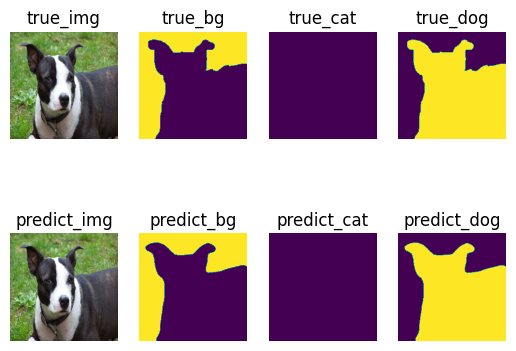

413/413 [==============================] - 196s 474ms/step - loss: 0.1025 - IoU: 0.8738 - sensitivity: 0.9261 - specificity: 0.9630 - val_loss: 0.1258 - val_IoU: 0.8426 - val_sensitivity: 0.9042 - val_specificity: 0.9521 - lr: 1.0000e-05
Epoch 43/50
114/413 [=======>......................] - ETA: 2:11 - loss: 0.0792 - IoU: 0.8927 - sensitivity: 0.9394 - specificity: 0.9697

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


210/413 [==============>...............] - ETA: 1:30 - loss: 0.0992 - IoU: 0.8747 - sensitivity: 0.9264 - specificity: 0.9632

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 25ms/step- loss: 0.0879 - IoU: 0.8809 - sensitivity: 0.9312 - specificity: 0.96


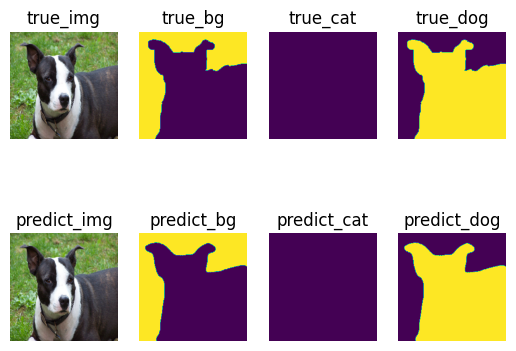

413/413 [==============================] - 194s 468ms/step - loss: 0.0879 - IoU: 0.8809 - sensitivity: 0.9312 - specificity: 0.9656 - val_loss: 0.1044 - val_IoU: 0.8687 - val_sensitivity: 0.9239 - val_specificity: 0.9620 - lr: 1.0000e-05
Epoch 44/50
339/413 [=======================>......] - ETA: 30s - loss: 0.1021 - IoU: 0.8705 - sensitivity: 0.9236 - specificity: 0.9618

Corrupt JPEG data: premature end of data segment


406/413 [============================>.] - ETA: 2s - loss: 0.1083 - IoU: 0.8606 - sensitivity: 0.9176 - specificity: 0.9588

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.1084 - IoU: 0.8604 - sensitivity: 0.9176 - specificity: 0.95


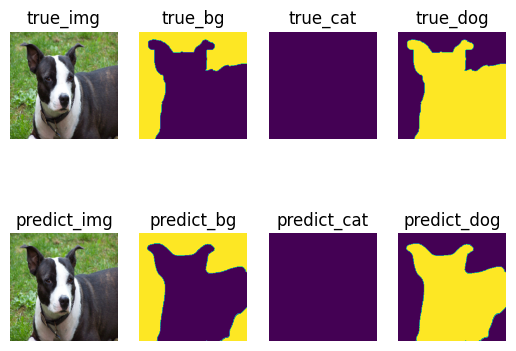

413/413 [==============================] - 188s 455ms/step - loss: 0.1084 - IoU: 0.8604 - sensitivity: 0.9176 - specificity: 0.9588 - val_loss: 0.1280 - val_IoU: 0.8250 - val_sensitivity: 0.8960 - val_specificity: 0.9480 - lr: 1.0000e-05
Epoch 45/50
102/413 [======>.......................] - ETA: 2:10 - loss: 0.0821 - IoU: 0.8657 - sensitivity: 0.9237 - specificity: 0.9618

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


155/413 [==========>...................] - ETA: 1:49 - loss: 0.0774 - IoU: 0.8712 - sensitivity: 0.9271 - specificity: 0.9635

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 21ms/step- loss: 0.0741 - IoU: 0.8843 - sensitivity: 0.9351 - specificity: 0.96


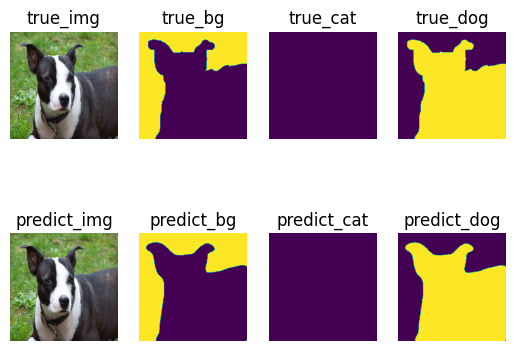

413/413 [==============================] - 189s 457ms/step - loss: 0.0741 - IoU: 0.8843 - sensitivity: 0.9351 - specificity: 0.9675 - val_loss: 0.0936 - val_IoU: 0.8716 - val_sensitivity: 0.9258 - val_specificity: 0.9629 - lr: 1.0000e-05
Epoch 46/50
 78/413 [====>.........................] - ETA: 2:22 - loss: 0.0593 - IoU: 0.9064 - sensitivity: 0.9484 - specificity: 0.9742

Corrupt JPEG data: premature end of data segment


217/413 [==============>...............] - ETA: 1:22 - loss: 0.0648 - IoU: 0.9045 - sensitivity: 0.9469 - specificity: 0.9734

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 22ms/step- loss: 0.0878 - IoU: 0.8810 - sensitivity: 0.9314 - specificity: 0.96


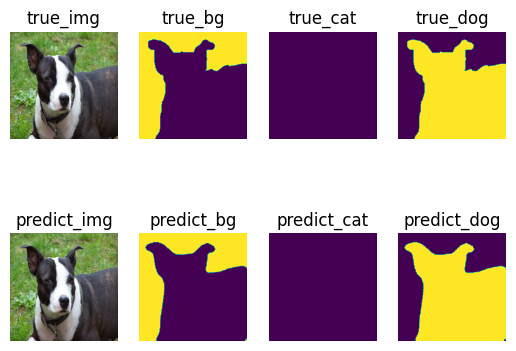

413/413 [==============================] - 189s 457ms/step - loss: 0.0878 - IoU: 0.8810 - sensitivity: 0.9314 - specificity: 0.9657 - val_loss: 0.0978 - val_IoU: 0.8549 - val_sensitivity: 0.9154 - val_specificity: 0.9577 - lr: 1.0000e-05
Epoch 47/50
311/413 [=====================>........] - ETA: 42s - loss: 0.0863 - IoU: 0.8740 - sensitivity: 0.9276 - specificity: 0.9638

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


354/413 [========================>.....] - ETA: 24s - loss: 0.0846 - IoU: 0.8764 - sensitivity: 0.9293 - specificity: 0.9646

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 21ms/step- loss: 0.0841 - IoU: 0.8772 - sensitivity: 0.9298 - specificity: 0.96


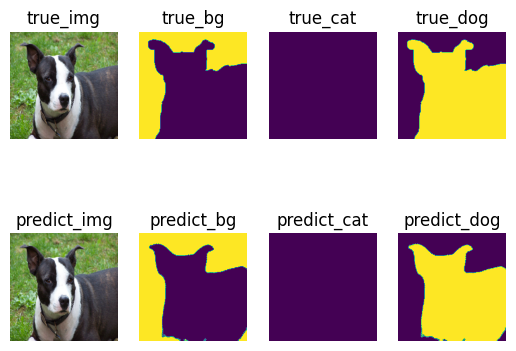

413/413 [==============================] - 188s 454ms/step - loss: 0.0841 - IoU: 0.8772 - sensitivity: 0.9298 - specificity: 0.9649 - val_loss: 0.1680 - val_IoU: 0.8076 - val_sensitivity: 0.8829 - val_specificity: 0.9415 - lr: 1.0000e-05
Epoch 48/50
190/413 [============>.................] - ETA: 1:33 - loss: 0.1660 - IoU: 0.8028 - sensitivity: 0.8739 - specificity: 0.9370

Corrupt JPEG data: premature end of data segment


341/413 [=======================>......] - ETA: 30s - loss: 0.1650 - IoU: 0.8065 - sensitivity: 0.8775 - specificity: 0.9387

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 20ms/step- loss: 0.1522 - IoU: 0.8180 - sensitivity: 0.8859 - specificity: 0.94


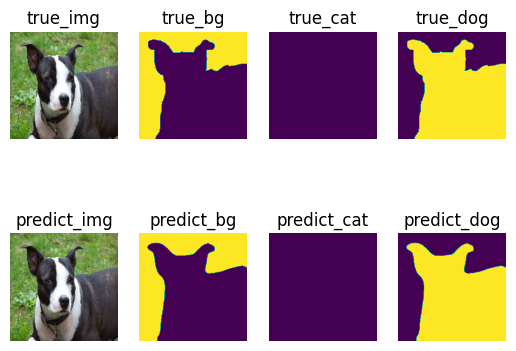

413/413 [==============================] - 190s 460ms/step - loss: 0.1522 - IoU: 0.8180 - sensitivity: 0.8859 - specificity: 0.9430 - val_loss: 0.1167 - val_IoU: 0.8482 - val_sensitivity: 0.9095 - val_specificity: 0.9548 - lr: 1.0000e-05
Epoch 49/50
148/413 [=========>....................] - ETA: 1:51 - loss: 0.0764 - IoU: 0.8886 - sensitivity: 0.9368 - specificity: 0.9684

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


285/413 [===================>..........] - ETA: 53s - loss: 0.0815 - IoU: 0.8832 - sensitivity: 0.9334 - specificity: 0.9667

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 20ms/step- loss: 0.0906 - IoU: 0.8774 - sensitivity: 0.9295 - specificity: 0.96


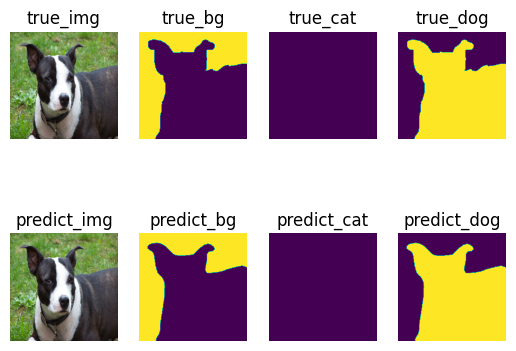

413/413 [==============================] - 189s 456ms/step - loss: 0.0906 - IoU: 0.8774 - sensitivity: 0.9295 - specificity: 0.9647 - val_loss: 0.1178 - val_IoU: 0.8514 - val_sensitivity: 0.9111 - val_specificity: 0.9556 - lr: 1.0000e-05
Epoch 50/50
366/413 [=========================>....] - ETA: 19s - loss: 0.0857 - IoU: 0.8874 - sensitivity: 0.9356 - specificity: 0.9678

Corrupt JPEG data: premature end of data segment


375/413 [==========================>...] - ETA: 15s - loss: 0.0851 - IoU: 0.8876 - sensitivity: 0.9358 - specificity: 0.9679

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 21ms/step- loss: 0.0841 - IoU: 0.8887 - sensitivity: 0.9365 - specificity: 0.96


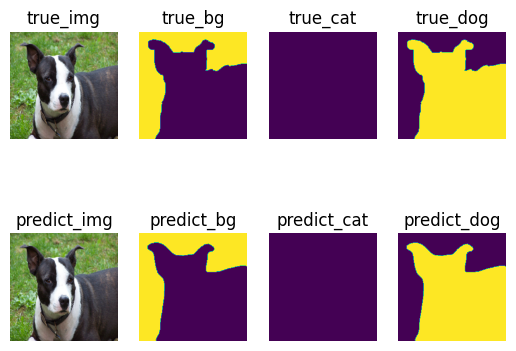

1/1 [==============================] - 0s 24ms/step
INFO:tensorflow:Assets written to: /tmp/tmpa8hxbm55/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpa8hxbm55/model/data/model/assets
2023/11/27 01:39:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpa8hxbm55/model, flavor: tensorflow), fall back to return ['tensorflow==2.14.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
/home/rjomega/miniconda3/envs/cat_dog_segmentation/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [36]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Cat vs Dog Semantic Segmentation")

with mlflow.start_run(run_name="Custom DiceLoss v2 gamma=1 norm=(-1,1) imbalance dataset"):

    epochs = 50
    learning_rate = 1e-5

    VGG16_Unet_model = VGG16_Unet(n_classes = 3)

    VGG16_Unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss=DiceLoss(),
                metrics=[IoU,sensitivity,specificity])
    
    model_history = VGG16_Unet_model.fit(loaded_train_dataset,
                                  steps_per_epoch = len(loaded_train_dataset),
                                  epochs = epochs,
                                  callbacks = [
                                            #tf.keras.callbacks.ModelCheckpoint(saveModelCheckPoint(), \
                                            #save_best_only=True, mode='min'), \
                                            tf.keras.callbacks.ReduceLROnPlateau(),
                                            plot_predict_per_epoch(VGG16_Unet_model),
                                        ],
                                  validation_data = loaded_valid_dataset,
                                  validation_steps = len(loaded_valid_dataset),
                                    )
    
    mlflow.log_params(
        {
            "learning_rate": learning_rate,
            "batch_size": 16,
            "epochs": epochs,
            "gamma_dice_loss": 1,
        }
    )

    for i in range(epochs):
      for key,val in model_history.history.items():
          mlflow.log_metric(key,val[i],step=i)
          
    mlflow.set_tags(
        {
            "base_model": "UNet",
            "encoder": "VGG16",
            "loss": "custom DiceLoss",
            "data split": "imbalance"
        }
    )

    img,mask = loaded_valid_dataset.dataset[50]
    input_signature = np.expand_dims(img, axis=0)

    signature = mlflow.models.infer_signature(input_signature,VGG16_Unet_model.predict(input_signature))

    mlflow.tensorflow.log_model(VGG16_Unet_model,
                                custom_objects=
                                {
                                  "DiceLoss":DiceLoss(),
                                  "IoU":IoU,
                                  "classification_metrics":classification_metrics,
                                  "sensitivity":sensitivity,
                                  "specificity":specificity
                                },
                                artifact_path='model',
                                signature=signature
                                )


In [77]:
exit()

Epoch 1/2
 49/410 [==>...........................] - ETA: 2:57 - loss: 0.0963 - IoU: 0.3072 - sensitivity: 0.4685 - specificity: 0.7709

Corrupt JPEG data: premature end of data segment


 55/410 [===>..........................] - ETA: 2:54 - loss: 0.0937 - IoU: 0.3070 - sensitivity: 0.4687 - specificity: 0.7730

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 278ms/step loss: 0.0419 - IoU: 0.4530 - sensitivity: 0.6174 - specificity: 0.85


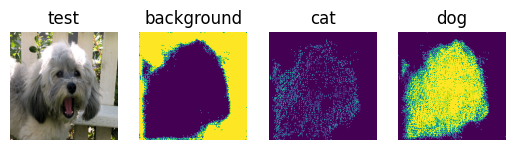

410/410 [==============================] - 231s 549ms/step - loss: 0.0419 - IoU: 0.4530 - sensitivity: 0.6174 - specificity: 0.8591 - val_loss: 0.0219 - val_IoU: 0.5728 - val_sensitivity: 0.7197 - val_specificity: 0.9007 - lr: 1.0000e-05
Epoch 2/2
  9/410 [..............................] - ETA: 3:26 - loss: 0.0260 - IoU: 0.5608 - sensitivity: 0.6990 - specificity: 0.8929

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


304/410 [=====================>........] - ETA: 53s - loss: 0.0198 - IoU: 0.5657 - sensitivity: 0.7101 - specificity: 0.9040

Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 25ms/step- loss: 0.0187 - IoU: 0.5774 - sensitivity: 0.7195 - specificity: 0.90


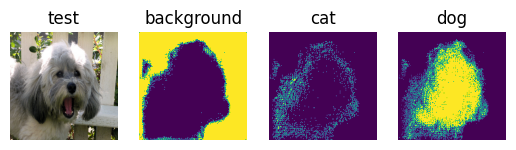

410/410 [==============================] - 225s 549ms/step - loss: 0.0187 - IoU: 0.5774 - sensitivity: 0.7195 - specificity: 0.9079 - val_loss: 0.0194 - val_IoU: 0.6097 - val_sensitivity: 0.7288 - val_specificity: 0.9140 - lr: 1.0000e-05


In [134]:
model_history = VGG16_Unet.fit(loaded_train_dataset,
                                  steps_per_epoch = len(loaded_train_dataset),
                                  epochs = 2,
                                  callbacks = callbacks,
                                  validation_data = loaded_valid_dataset,
                                  validation_steps = len(loaded_valid_dataset),
                                    )

#VGG16_Unet.save('model_run_subclass_split_dice_224trainable.h5')

In [102]:
tversky_history = model_history.history
tversky_history

{'loss': [0.059543874114751816,
  0.019652102142572403,
  0.01455051451921463,
  0.010289186611771584,
  0.009859474375844002],
 'IoU': [0.41986319422721863,
  0.569592297077179,
  0.6217413544654846,
  0.6795719861984253,
  0.691878616809845],
 'sensitivity': [0.580864667892456,
  0.7162286639213562,
  0.7596367001533508,
  0.8172798752784729,
  0.8266849517822266],
 'specificity': [0.845649242401123,
  0.9063762426376343,
  0.9200296401977539,
  0.9344885349273682,
  0.9386740326881409],
 'val_loss': [0.022918913513422012,
  0.016162827610969543,
  0.012576734647154808,
  0.008047748357057571,
  0.007565842941403389],
 'val_IoU': [0.5625423192977905,
  0.6140092015266418,
  0.6590538620948792,
  0.7206494212150574,
  0.7237955927848816],
 'val_sensitivity': [0.7103188037872314,
  0.74563068151474,
  0.7829134464263916,
  0.8517695665359497,
  0.8517464995384216],
 'val_specificity': [0.8983793258666992,
  0.9166856408119202,
  0.9308288097381592,
  0.9438393115997314,
  0.94344735145

In [99]:
focal_history = model_history.history
focal_history

{'loss': [0.05135609209537506,
  0.019954241812229156,
  0.01525825448334217,
  0.011863002553582191,
  0.008334328420460224],
 'IoU': [0.40005210041999817,
  0.5728564262390137,
  0.6110286116600037,
  0.6600683927536011,
  0.7138285636901855],
 'sensitivity': [0.5664148330688477,
  0.7192254066467285,
  0.7483044862747192,
  0.7958298921585083,
  0.8460447192192078],
 'specificity': [0.8452677130699158,
  0.9045518040657043,
  0.9161888360977173,
  0.927779495716095,
  0.941238522529602],
 'val_loss': [0.02373068779706955,
  0.017075560986995697,
  0.012890415266156197,
  0.00909373164176941,
  0.00746580446138978],
 'val_IoU': [0.5296993255615234,
  0.5663092136383057,
  0.6385079622268677,
  0.6917321085929871,
  0.7380669116973877],
 'val_sensitivity': [0.6843970417976379,
  0.7168799638748169,
  0.7797473073005676,
  0.8304076194763184,
  0.8613989353179932],
 'val_specificity': [0.8939825892448425,
  0.9118280410766602,
  0.9198805689811707,
  0.9385507106781006,
  0.94601482152

In [94]:
dice_history = model_history.history
dice_history

{'loss': [0.6181313991546631,
  0.4960671663284302,
  0.4721486568450928,
  0.4458601474761963,
  0.4238026738166809],
 'IoU': [0.46248722076416016,
  0.6329129338264465,
  0.6565908789634705,
  0.7164328694343567,
  0.7849892377853394],
 'sensitivity': [0.5951640605926514,
  0.758439838886261,
  0.7810540795326233,
  0.8248686790466309,
  0.8710228800773621],
 'specificity': [0.8062665462493896,
  0.8800718188285828,
  0.8908841609954834,
  0.9126377701759338,
  0.9358757138252258],
 'val_loss': [0.4860736131668091,
  0.4547322690486908,
  0.40946632623672485,
  0.37475448846817017,
  0.3504807949066162],
 'val_IoU': [0.618803858757019,
  0.6556723117828369,
  0.6878499984741211,
  0.7553768157958984,
  0.7990294694900513],
 'val_sensitivity': [0.7441102862358093,
  0.7750934362411499,
  0.8059685230255127,
  0.8510249257087708,
  0.8800293207168579],
 'val_specificity': [0.8732796311378479,
  0.8880832195281982,
  0.903194010257721,
  0.9257466197013855,
  0.9404032826423645],
 'lr':

In [112]:
exit()

In [111]:
dice_history.items()

dict_items([('loss', [0.6181313991546631, 0.4960671663284302, 0.4721486568450928, 0.4458601474761963, 0.4238026738166809]), ('IoU', [0.46248722076416016, 0.6329129338264465, 0.6565908789634705, 0.7164328694343567, 0.7849892377853394]), ('sensitivity', [0.5951640605926514, 0.758439838886261, 0.7810540795326233, 0.8248686790466309, 0.8710228800773621]), ('specificity', [0.8062665462493896, 0.8800718188285828, 0.8908841609954834, 0.9126377701759338, 0.9358757138252258]), ('val_loss', [0.4860736131668091, 0.4547322690486908, 0.40946632623672485, 0.37475448846817017, 0.3504807949066162]), ('val_IoU', [0.618803858757019, 0.6556723117828369, 0.6878499984741211, 0.7553768157958984, 0.7990294694900513]), ('val_sensitivity', [0.7441102862358093, 0.7750934362411499, 0.8059685230255127, 0.8510249257087708, 0.8800293207168579]), ('val_specificity', [0.8732796311378479, 0.8880832195281982, 0.903194010257721, 0.9257466197013855, 0.9404032826423645]), ('lr', [1e-05, 1e-05, 1e-05, 1e-05, 1e-05])])

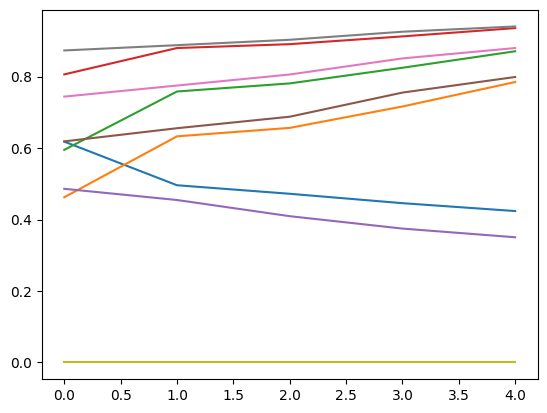

In [110]:
fig, arr = plt.subplots()

for key,val in dice_history.items():
    arr.plot(val)

In [ ]:
fig, arr = plt.subplots()



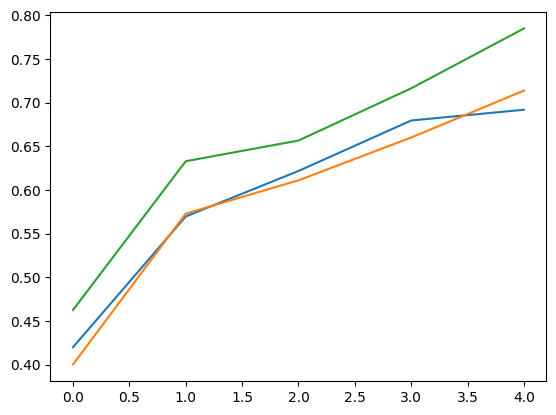

In [106]:
plt.plot(tversky_history['IoU'])
plt.plot(focal_history['IoU'])
plt.plot(dice_history['IoU'])
plt.show()

In [ ]:
img,mask = valid_dataset[5]

img_inp = np.expand_dims(img, axis = 0)
predict_mask = VGG16_Unet.predict(img_inp)

threshold = 0.5
predict_mask = np.where(predict_mask > threshold, 1, 0)

plt.subplot(1,4,1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(predict_mask[...,0].squeeze())
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(predict_mask[...,1].squeeze())
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(predict_mask[...,2].squeeze())
plt.axis('off')

: 

: 

### Load Model

In [ ]:
custom_objects = {'DiceLoss': DiceLoss}
loaded_model = tf.keras.models.load_model('model_run_subclass_split_dice_224trainable.keras')#,custom_objects=custom_objects, compile=False)

TypeError: Could not locate class 'DiceLoss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'DiceLoss', 'config': {'reduction': 'auto', 'name': 'DiceLoss'}, 'registered_name': 'DiceLoss'}

In [ ]:
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=DiceLoss(),
              #loss = 'categorical_crossentropy',
              metrics=['accuracy'])

### Predict from custom data

1/1 [==============================] - 0s 263ms/step


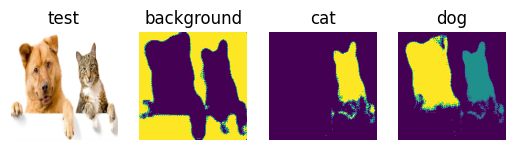

In [ ]:
import urllib

def preprocess_predict(img):
    preprocessed_img = cv2.resize(img,(224,224),interpolation=cv2.INTER_LINEAR)
    return preprocessed_img


def img_loader(url):
    response = urllib.request.urlopen(url)
    img = np.asarray(bytearray(response.read()), dtype="uint8")
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # resize
    preprocessed_img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)

    # normalize
    preprocessed_img = preprocessed_img/255

    # preprocess for model prediction
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)

    # generate mask from model
    predict_mask = loaded_model.predict(preprocessed_img)

    threshold = 0.9
    predict_mask = np.where(predict_mask > threshold, 1, 0)

    fig, arr = plt.subplots(1,4)

    arr[0].set_title('test')
    arr[0].imshow(preprocessed_img[0])
    arr[0].axis('off')
    arr[1].set_title('background')
    arr[1].imshow(predict_mask[...,0].squeeze())
    arr[1].axis('off')
    arr[2].set_title('cat')
    arr[2].imshow(predict_mask[...,1].squeeze())
    arr[2].axis('off')
    arr[3].set_title('dog')
    test = np.argmax(predict_mask[0],axis=-1)
    arr[3].imshow(test)#predict_mask[...,2].squeeze())
    arr[3].axis('off')

    #print(np.unique(test))

    return preprocessed_img, predict_mask

URL_ = "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg"
img, mask = img_loader(URL_)

### draw contour

In [ ]:
def draw_contour(img: np.ndarray, mask: np.ndarray, color:tuple=(0,255,0)) -> np.ndarray:
    """
    Overlay a contour of a mask over the image.

    Args:
        img: A 3D numpy array representing the three-channel
            image of the mask/contour.

        mask: A 3D numpy array representing a grayscale image.

    Returns:
        overlay: A 3D numpy array with overlay of the mask contour on the image.

    Raises:
        ValueError: If the image and mask do not have the same shape excluding 
            the number of channels.
    """

    if img.shape[:2] != mask.shape[:2]:
        raise ValueError("Image and Mask must have the same width and height")

    # update mask to the required dtype of cv2
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    # to prevent img from getting an overlay
    img_copy = img.copy()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay = cv2.drawContours(img_copy,contours,-1,color,thickness=2)

    return overlay

### centroid

$$c=\frac{1}{n} \sum^n_{i=1}{x_i}$$

In [ ]:
def centroid_calculator(img:np.ndarray,mask:np.ndarray,label:str,color:tuple=(0,0,0)):

    # update mask to the required dtype of cv2
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    M = cv2.moments(mask)

    Cx = int(M["m10"] / M["m00"])
    Cy = int(M["m01"] / M["m00"])

    # to prevent img from getting an overlay
    img_copy = img.copy()

    cv2.circle(img_copy,(Cx,Cy),5,color,-1)
    cv2.putText(img_copy,label,(Cx+10,Cy-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    return img_copy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


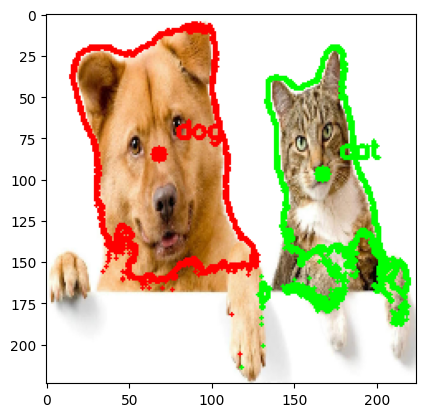

In [ ]:
mask_input = mask[0]
mask_cat = mask_input[...,1]
mask_dog = mask_input[...,2]

contour = draw_contour(img[0], mask_cat[...,np.newaxis],color=(0,255,0))
contour = draw_contour(contour, mask_dog[...,np.newaxis],color=(255,0,0))

label = centroid_calculator(contour,mask_cat[...,np.newaxis],"cat",(0,255,0))
label = centroid_calculator(label,mask_dog[...,np.newaxis],"dog",(255,0,0))

plt.imshow(label)

0.013529409 1.0
5.305651e-05 0.003921569


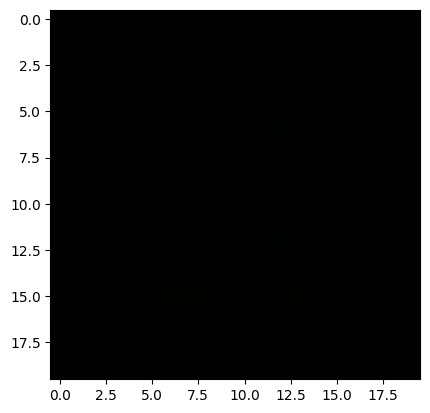

In [ ]:
resize =  tf.keras.layers.Resizing(20,20)
normalization = tf.keras.layers.Rescaling(1./255)
tf_img = resize(img[0])
print(np.min(tf_img), np.max(tf_img))
tf_img = normalization(tf_img)
plt.imshow(tf_img)
print(np.min(tf_img), np.max(tf_img))
